In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
%matplotlib inline

In [2]:
# Import cancellations and bookings datasets

cancellations = pd.read_csv('Client_Cancellations.csv')
bookings = pd.read_csv('Future_Bookings_All_Clients.csv')
services = pd.read_csv('Service Listing0.csv')

# Concatenate datasets into one

bookings = bookings.rename(columns={'Date': 'Booking Date'})
all_bookings = pd.concat([cancellations, bookings])

# Rename columns for ease of manipulation

all_bookings = all_bookings.reset_index(drop=True)
column_names = all_bookings.columns
column_names = ['booking_date', 'cancel_date', 'canceled_by', 'code', 'days', 'service', 'staff', 'time', 'time_int']
all_bookings.columns = column_names

# Change dates to date type rather than string

all_bookings.loc[:,['booking_date', 'cancel_date']] = all_bookings.loc[:,['booking_date', 'cancel_date']].apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y'))

# Include an indicator of whether canceled and sort by booking date

all_bookings['canceled'] = (all_bookings.cancel_date.isnull() == False)
all_bookings.sort_values('booking_date', inplace=True)
all_bookings = all_bookings.reset_index(drop=True)

# Add actual service name
all_bookings['service_name'] = np.nan

for row in np.arange(0, len(all_bookings)):
    service_name = services.loc[services.loc[services['Code'] == all_bookings.loc[row, 'service']].index, 'Desc'].values
    all_bookings.loc[row, 'service_name'] = service_name
    
all_bookings.rename({'service': 'service_code', 'service_name': 'service'}, axis=1, inplace=True)

# Slice out dates for April, May and June only (Q2)
# These months were included in both original datasets
# This means we can compare attended vs canceled

bookings_q2 = all_bookings.loc[(all_bookings.booking_date > '2018-03-31') & (all_bookings.booking_date < '2018-07-01'),]
bookings_q2.reset_index(drop=True, inplace=True)
bookings_q2.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,booking_date,cancel_date,canceled_by,code,days,service_code,staff,time,time_int,canceled,service
0,2018-04-01,NaT,NaN,SLEA01,NaN,CON,HOUSE,11:10:00 AM,670.0,False,Consultation
1,2018-04-03,NaT,NaN,THOW01,NaN,SBD,JJ,9:00:00 AM,540.0,False,Blowdry
2,2018-04-03,2018-05-10,JJ,KOOM01,-37.0,SHCW,JJ,NaN,NaN,True,Women's hair cut
3,2018-04-03,NaT,NaN,YATT01,NaN,SHCM,BECKY,11:00:00 AM,660.0,False,Men's hair cut
4,2018-04-03,2018-04-03,JJ,HILJ01,0.0,CFC,KELLY,NaN,NaN,True,Color full color


In [3]:
## Look at whether cancellations vary by service type

service_total_cancel = bookings_q2.groupby('service').aggregate(sum)
service_total_cancel = service_total_cancel.reset_index()

service_count = bookings_q2.service.value_counts().to_frame()
service_count = service_count.reset_index()
service_count.columns = ['service', 'count']

q2_service = pd.merge(service_total_cancel, service_count, left_on='service', right_on='service')
q2_service['prop_canceled'] = q2_service['canceled'] / q2_service['count']
q2_service['attended'] = q2_service['count'] - q2_service['canceled']
q2_service.head()

,service,days,time_int,canceled,count,prop_canceled,attended
0,Accent lights and color,0.0,16520.0,0.0,22,0.000000,22.0
1,Balayage,6.0,7910.0,7.0,17,0.411765,10.0
2,Blow dry bundle 5+1,0.0,12430.0,0.0,17,0.000000,17.0
3,Blowdry,174.0,156030.0,40.0,236,0.169492,196.0
4,Children (under 12),2.0,7370.0,2.0,11,0.181818,9.0


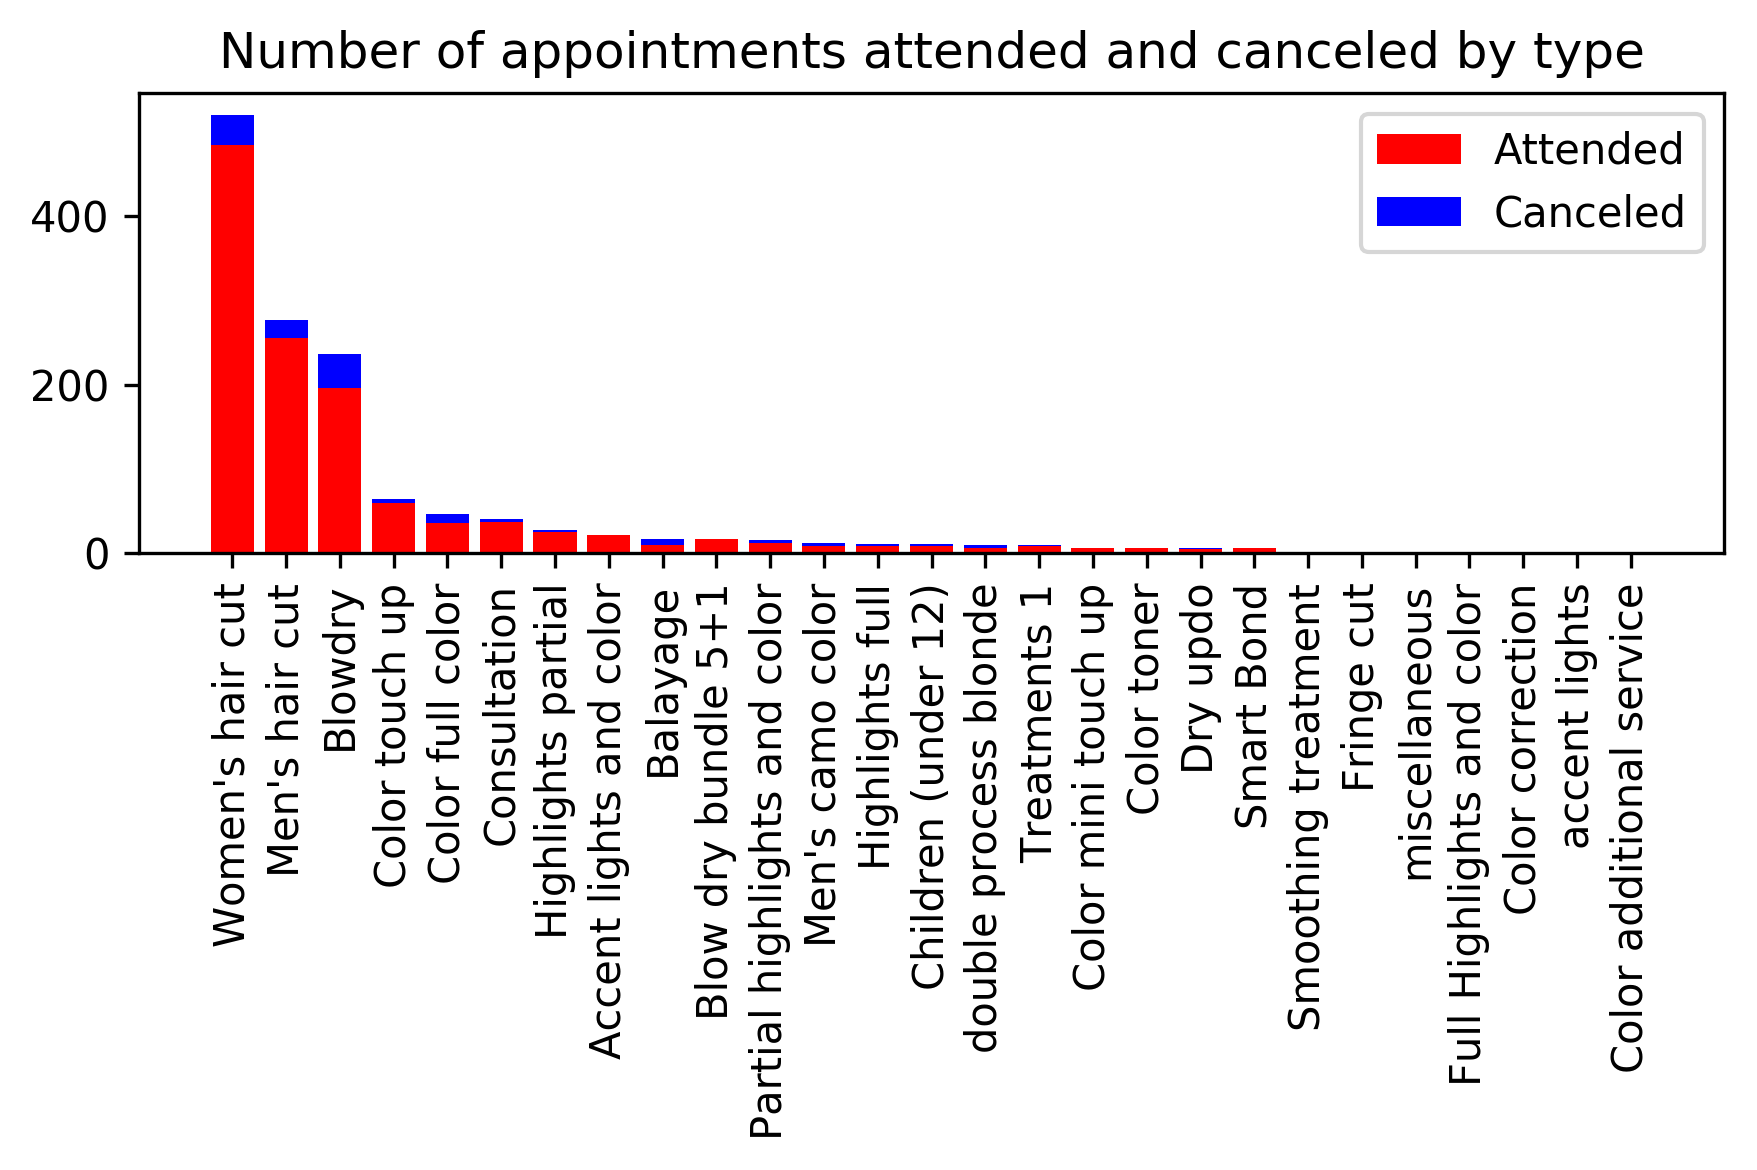

In [4]:
q2_service.sort_values('count', inplace=True, ascending=False)
fig = plt.figure(dpi=300)
p1 = plt.bar(x=q2_service['service'], height=(q2_service['count'] - q2_service['canceled']), color='red')
p2 = plt.bar(x='service', height='canceled', color='blue', data=q2_service, bottom=(q2_service['count'] - q2_service['canceled']))
plt.xticks(rotation='vertical')
plt.title('Number of appointments attended and canceled by type')
plt.legend(['Attended', 'Canceled'])
plt.tight_layout()
plt.savefig('canceled1.png')
plt.show()

In [ ]:
## Zoom in on top 3 so the others show up better

top3_services = ['Blowdry', "Women's hair cut", "Men's hair cut"]
q2_service_top3 = q2_service[q2_service.service.isin(top3_services)]
q2_service_nottop3 = q2_service[~q2_service.service.isin(top3_services)]

count_top3 = len(bookings_q2[bookings_q2.service.isin(top3_services)])
count_nottop3 = len(bookings_q2[~bookings_q2.service.isin(top3_services)])
count_top3 / (count_top3 + count_nottop3)

0.7501815541031227

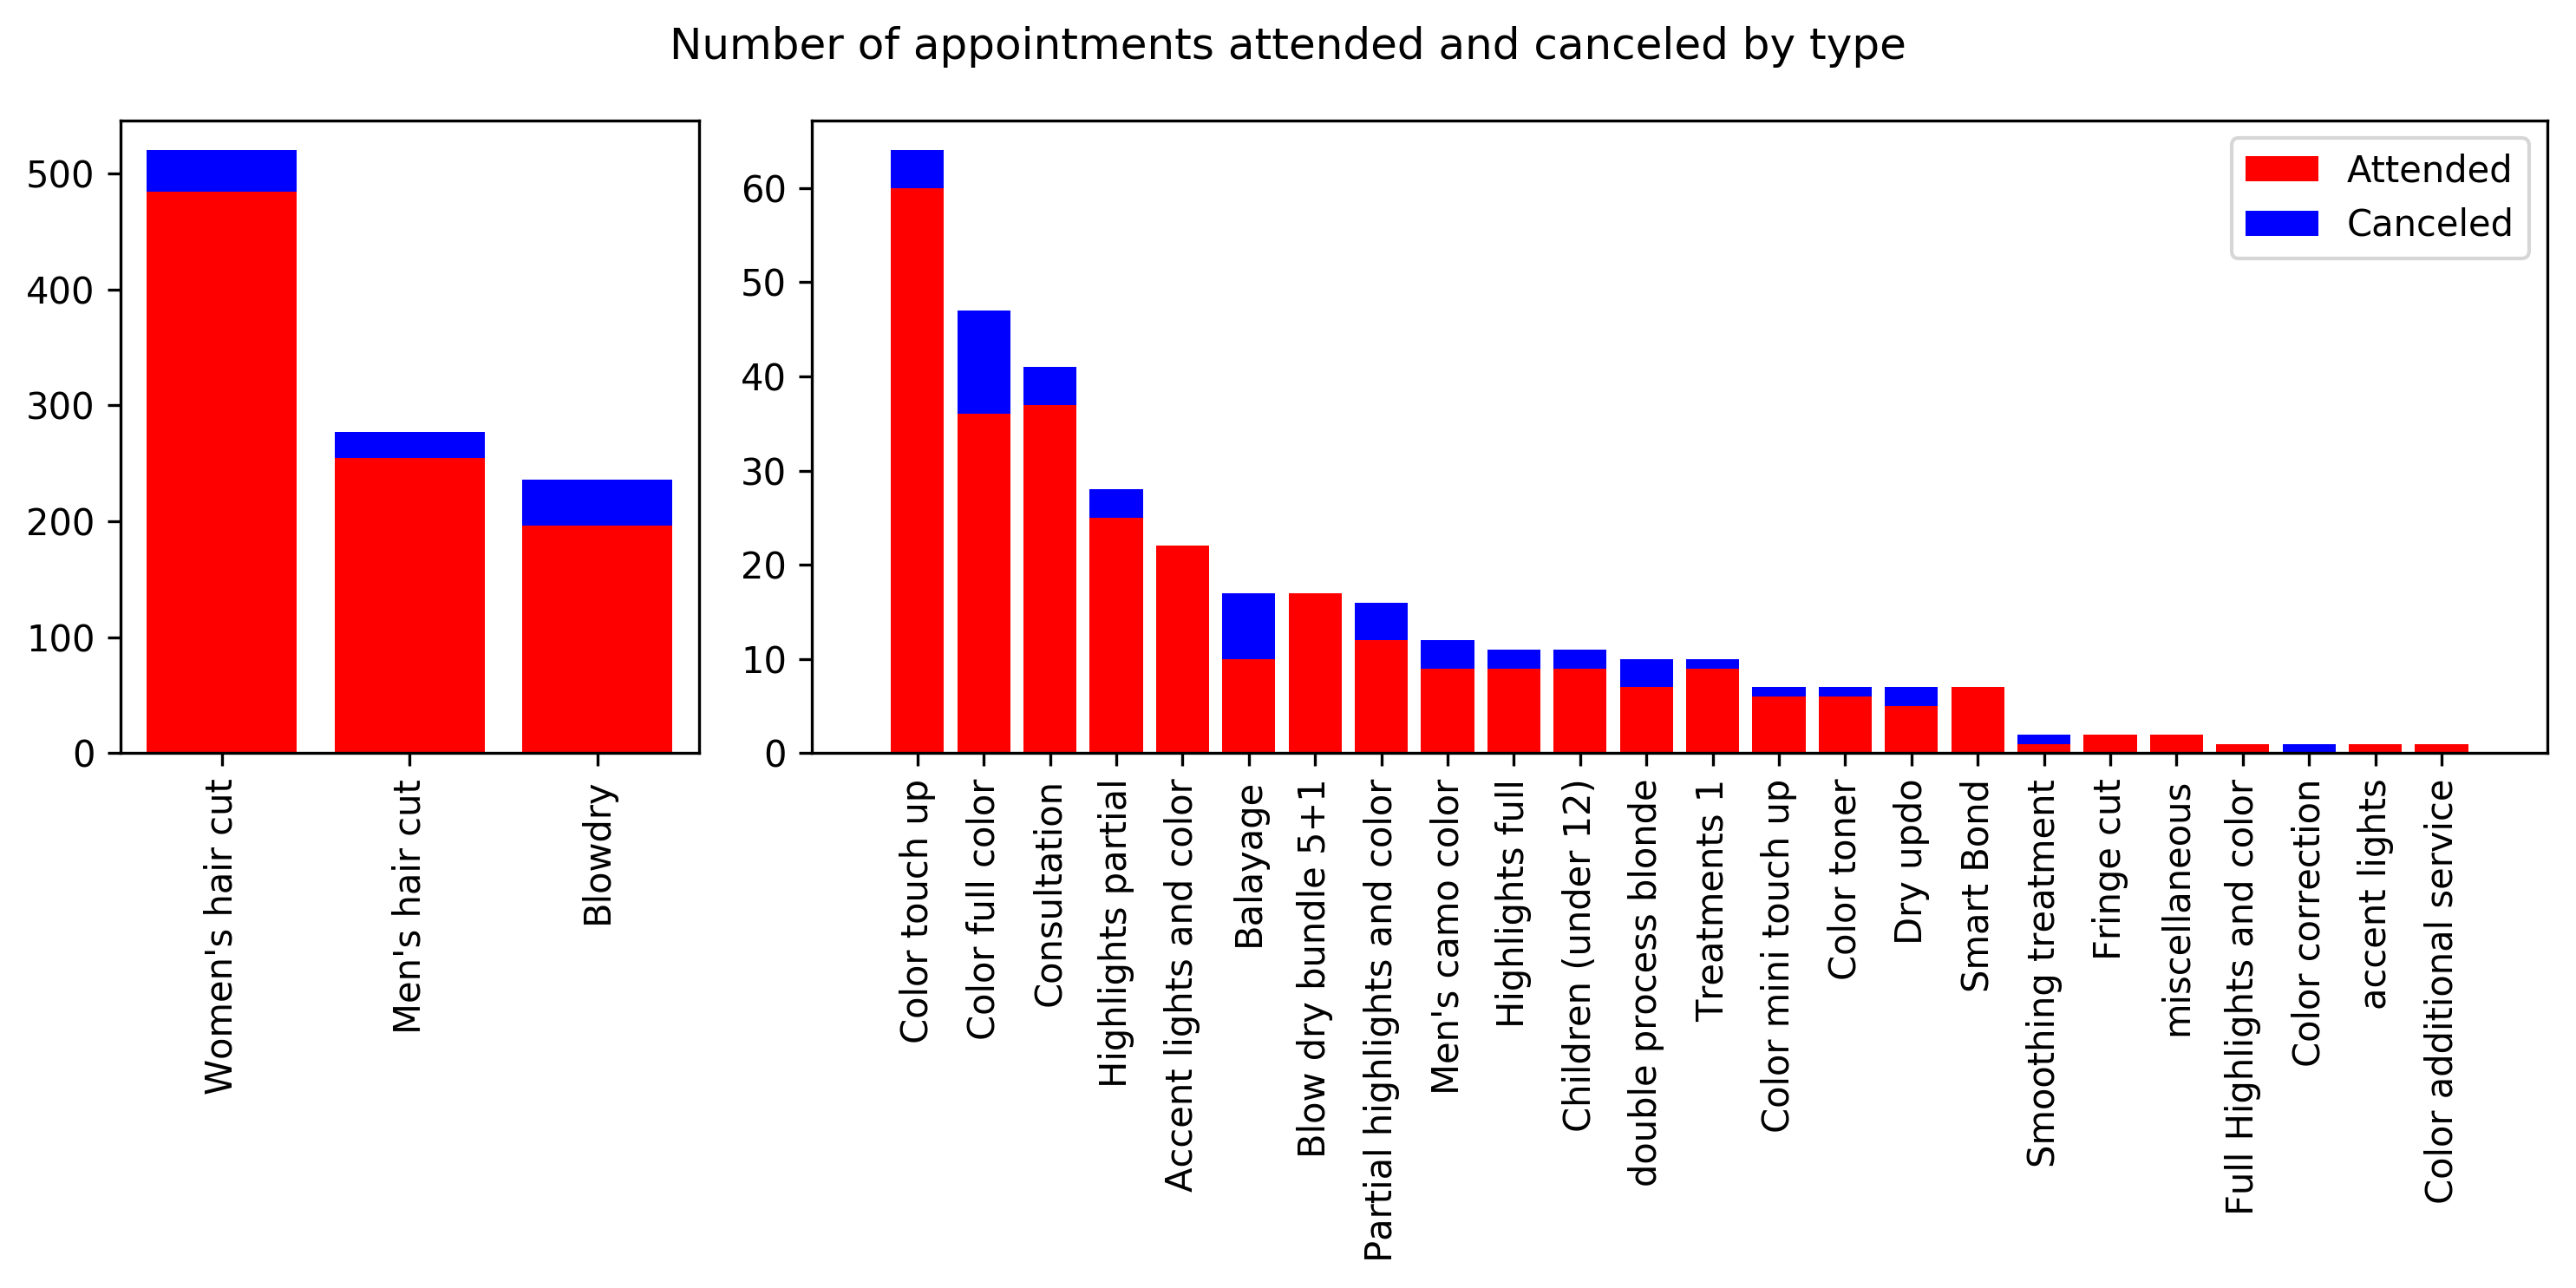

In [ ]:
# Zoom in to see less popular services more clearly.

fig = plt.figure(figsize=(10, 5), dpi=300)
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 3])

ax0 = plt.subplot(gs[0])
p1 = plt.bar(x=q2_service_top3['service'], height=q2_service_top3['attended'], color='red')
p2 = plt.bar(x=q2_service_top3['service'], height=q2_service_top3['canceled'], color='blue', bottom=(q2_service_top3['attended']))
plt.xticks(rotation='vertical')

ax1 = plt.subplot(gs[1])
p1 = plt.bar(x=q2_service_nottop3['service'], height=q2_service_nottop3['attended'], color='red')
p2 = plt.bar(x=q2_service_nottop3['service'], height=q2_service_nottop3['canceled'], color='blue', bottom=(q2_service_nottop3['attended']))
plt.legend(['Attended', 'Canceled'])
plt.xticks(rotation='vertical')

plt.suptitle('Number of appointments attended and canceled by type', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('canceled2.png')
plt.show()

## Improving the single graph

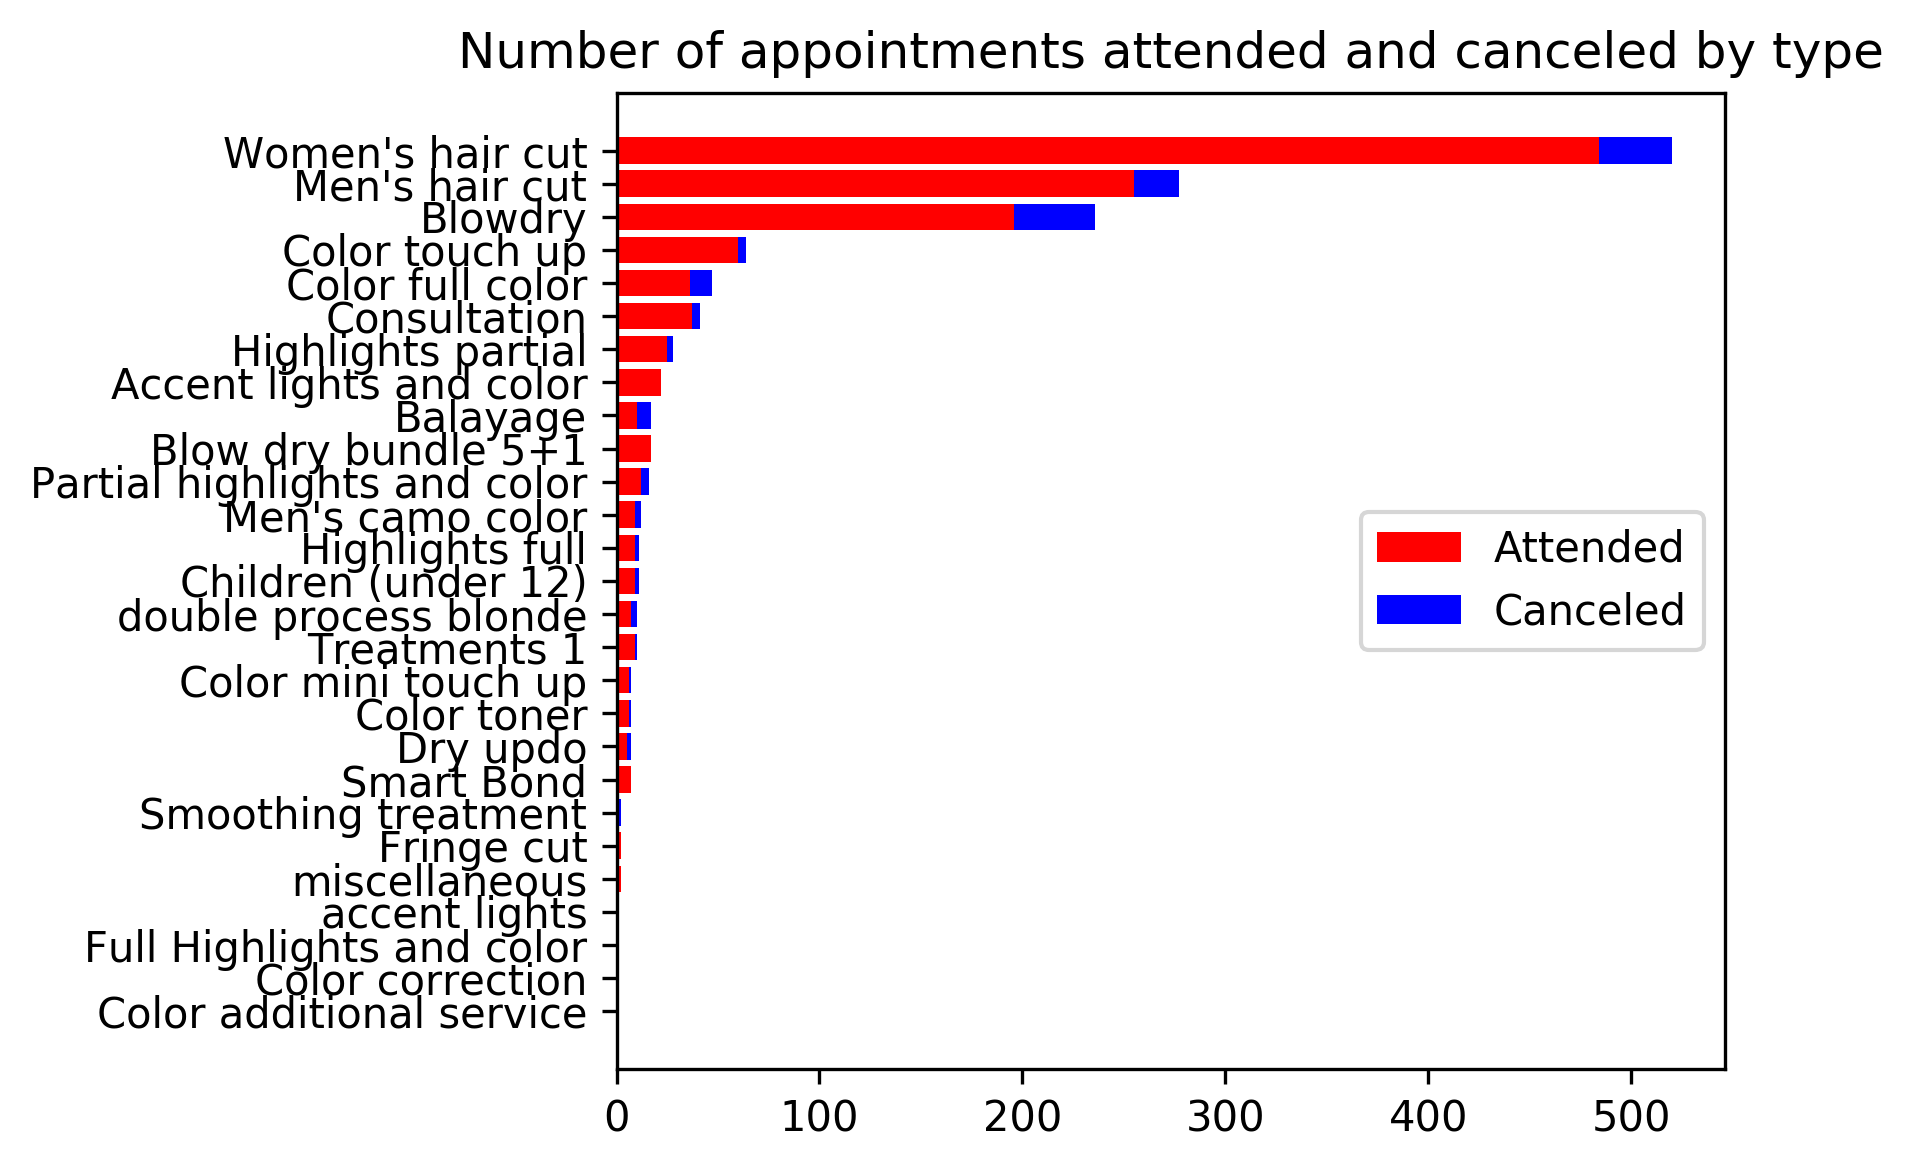

In [ ]:
## Flip round so don't have to turn head

q2_service.sort_values('count', inplace=True, ascending=True)

fig = plt.figure(dpi=300)
p1 = plt.barh(y=q2_service['service'], width=(q2_service['count'] - q2_service['canceled']), color='red')
p2 = plt.barh(y='service', width='canceled', color='blue', data=q2_service, left=(q2_service['count'] - q2_service['canceled']))
plt.title('Number of appointments attended and canceled by type')
plt.legend(['Attended', 'Canceled'], loc='center right')
plt.tight_layout()
plt.savefig('canceled3.png')
plt.show()

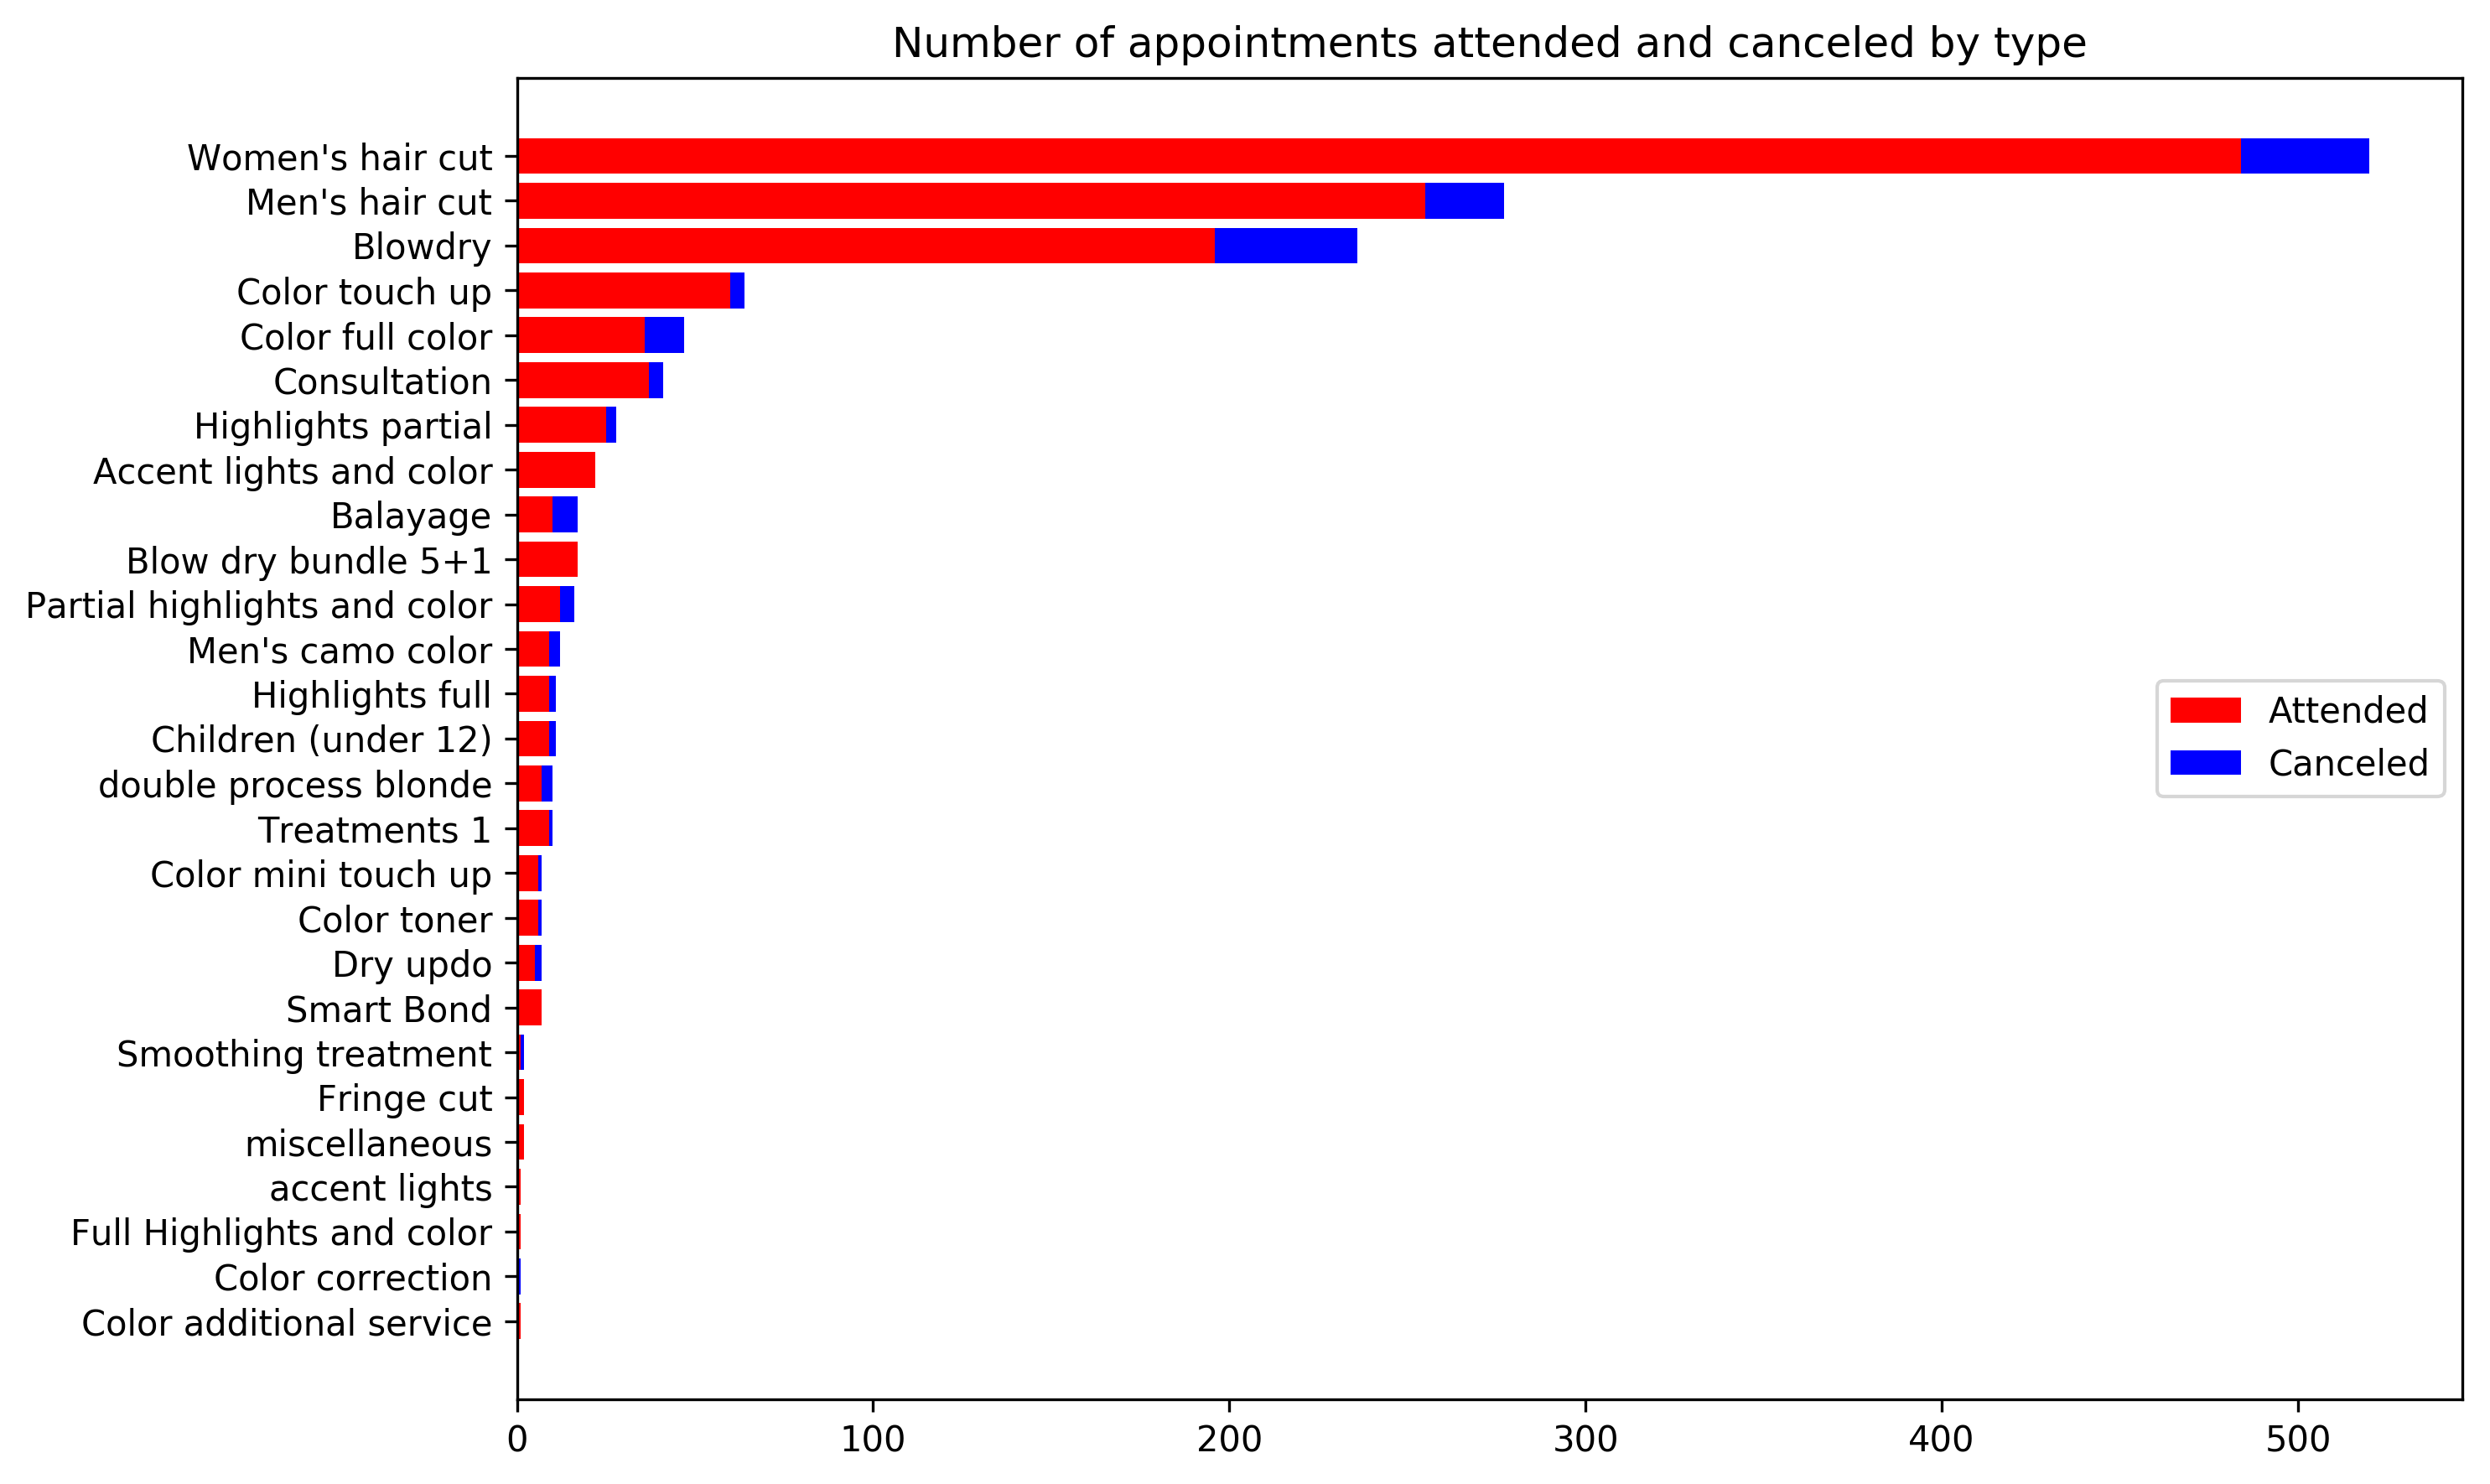

In [ ]:
## Improve spacing

fig = plt.figure(figsize=(10, 6), dpi=300)
p1 = plt.barh(y=q2_service['service'], width=(q2_service['count'] - q2_service['canceled']), color='red')
p2 = plt.barh(y='service', width='canceled', color='blue', data=q2_service, left=(q2_service['count'] - q2_service['canceled']))
plt.title('Number of appointments attended and canceled by type')
plt.legend(['Attended', 'Canceled'], loc='center right')
plt.tight_layout()
plt.savefig('canceled4.png')
plt.show()

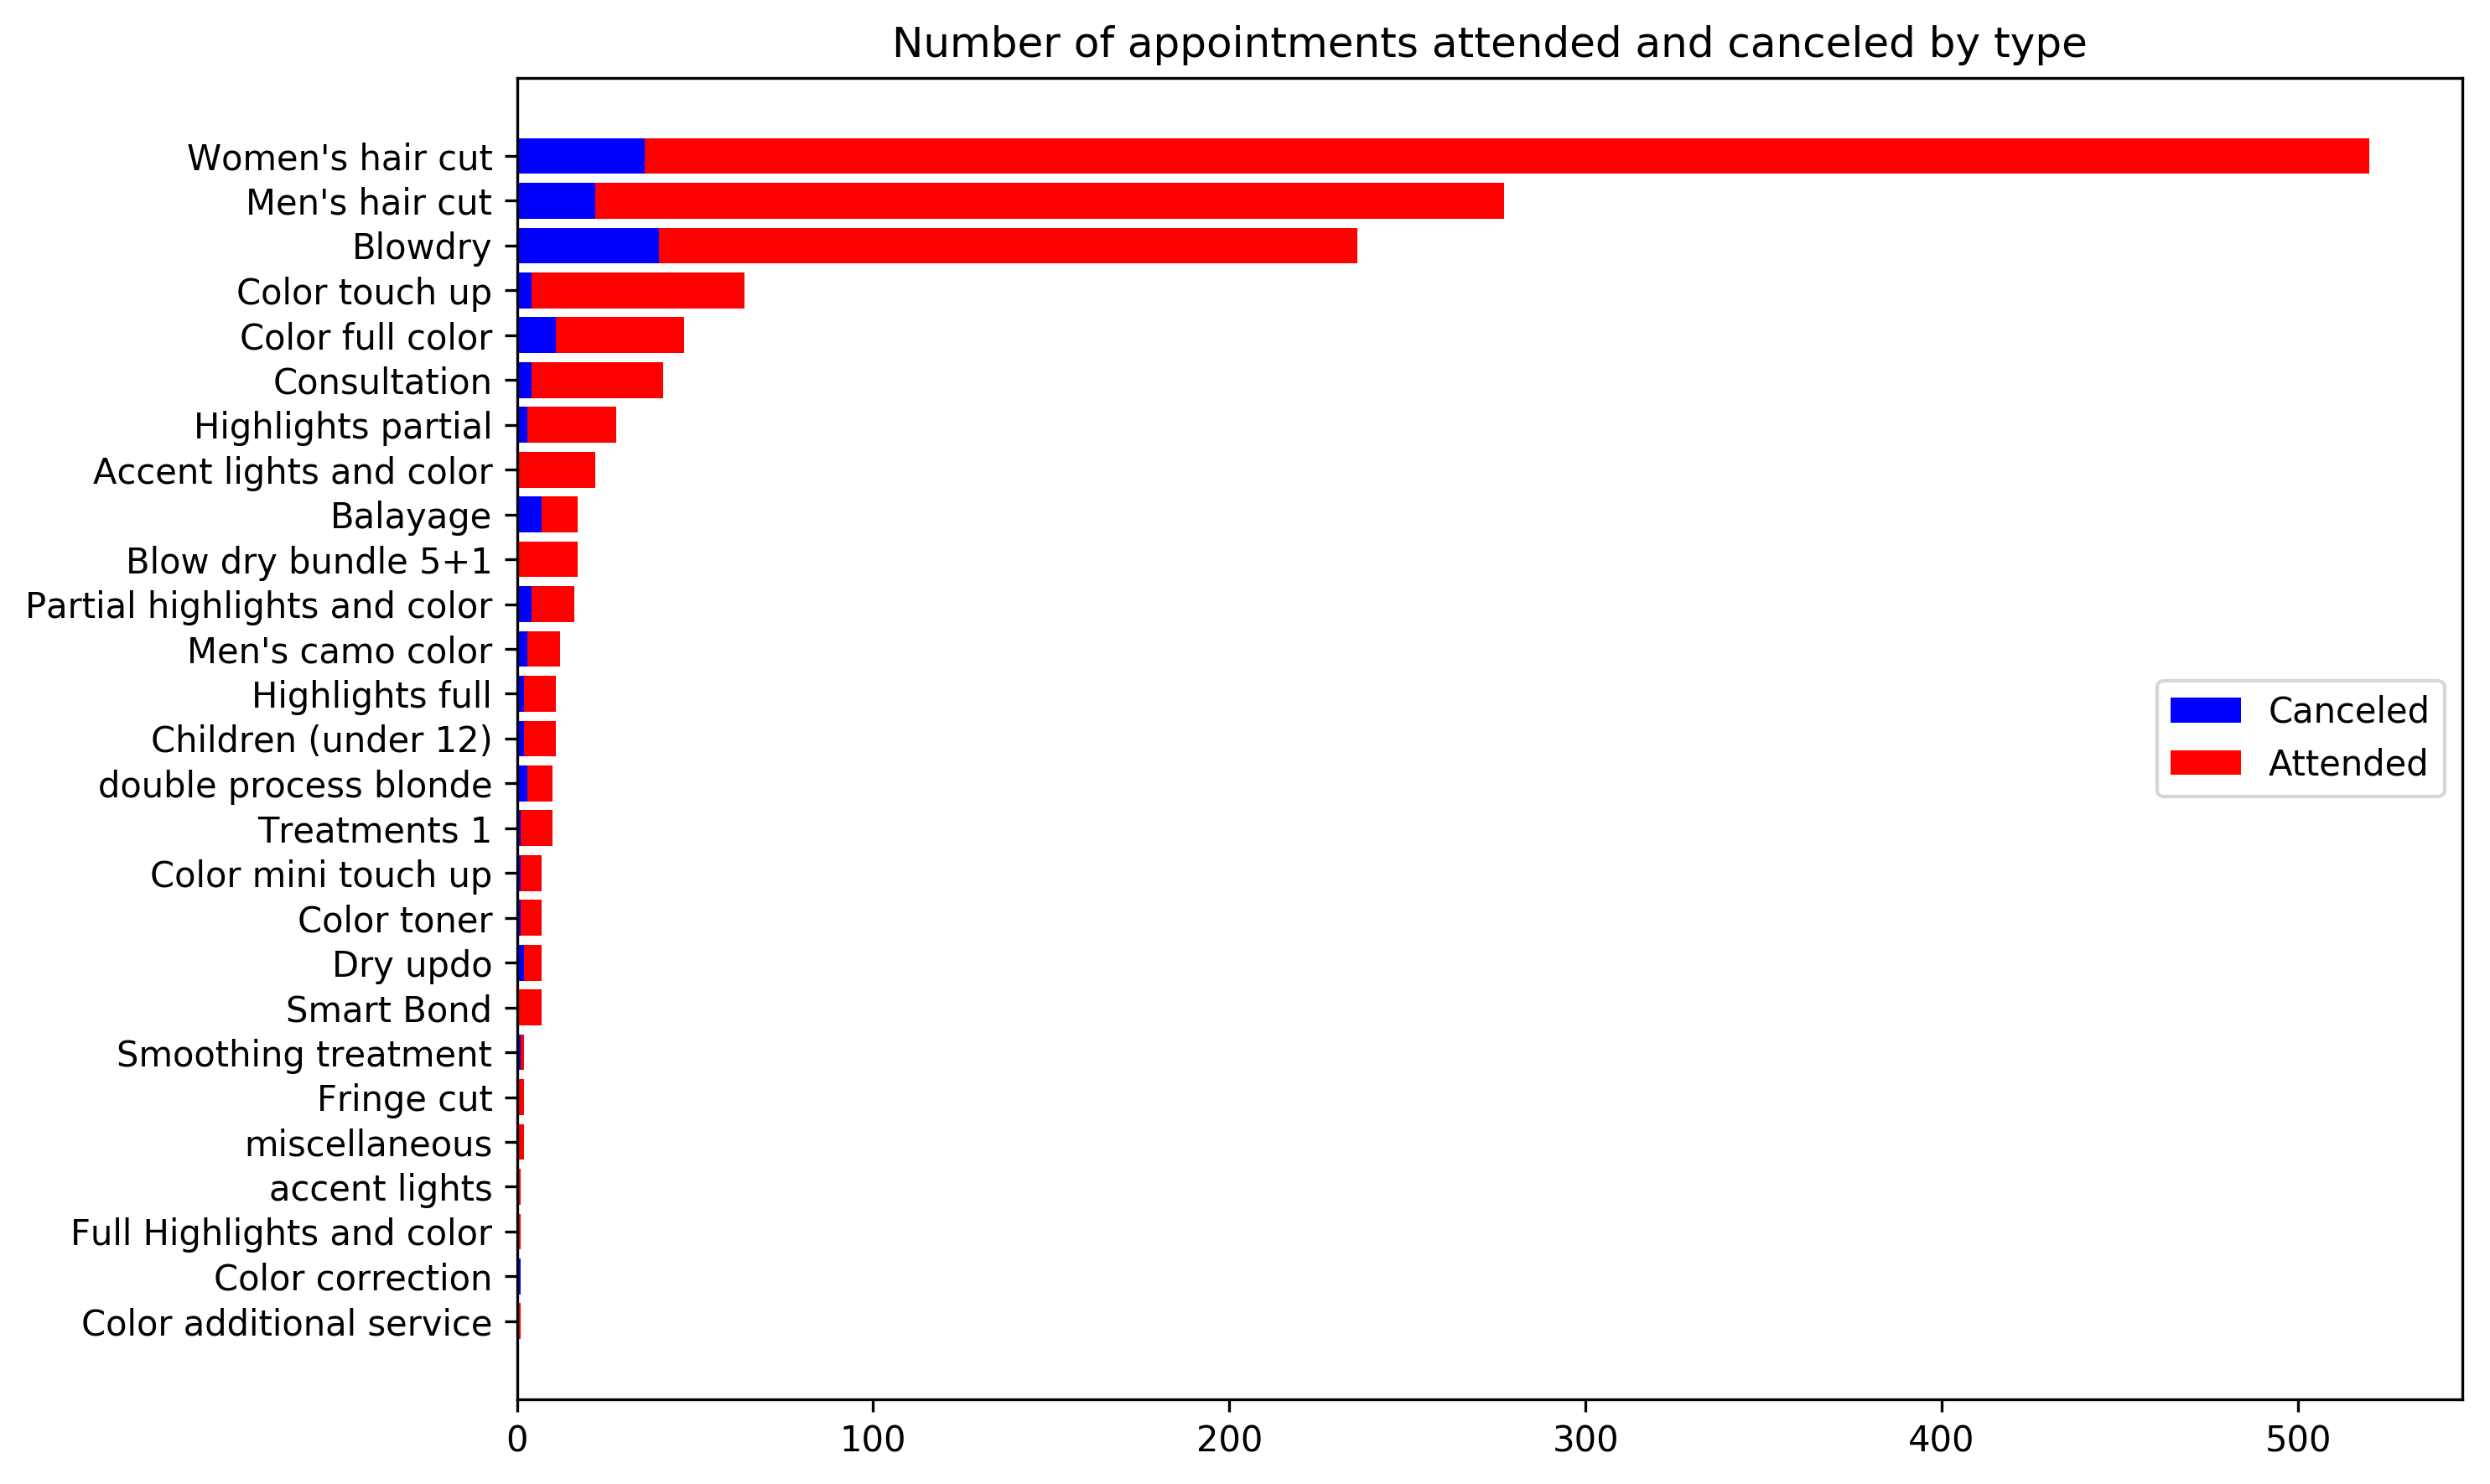

In [ ]:
## Hard to compare cancellations because at different places
## Switch round so all cancellations beside each other at base

fig = plt.figure(figsize=(10, 6), dpi=300)
p1 = plt.barh(y='service', width='canceled', color='blue', data=q2_service)
p2 = plt.barh(y=q2_service['service'], width=(q2_service['count'] - q2_service['canceled']), left=q2_service['canceled'], color='red')
plt.title('Number of appointments attended and canceled by type')
plt.legend(['Canceled', 'Attended'], loc='center right')
plt.tight_layout()
plt.savefig('canceled5.png')
plt.show()

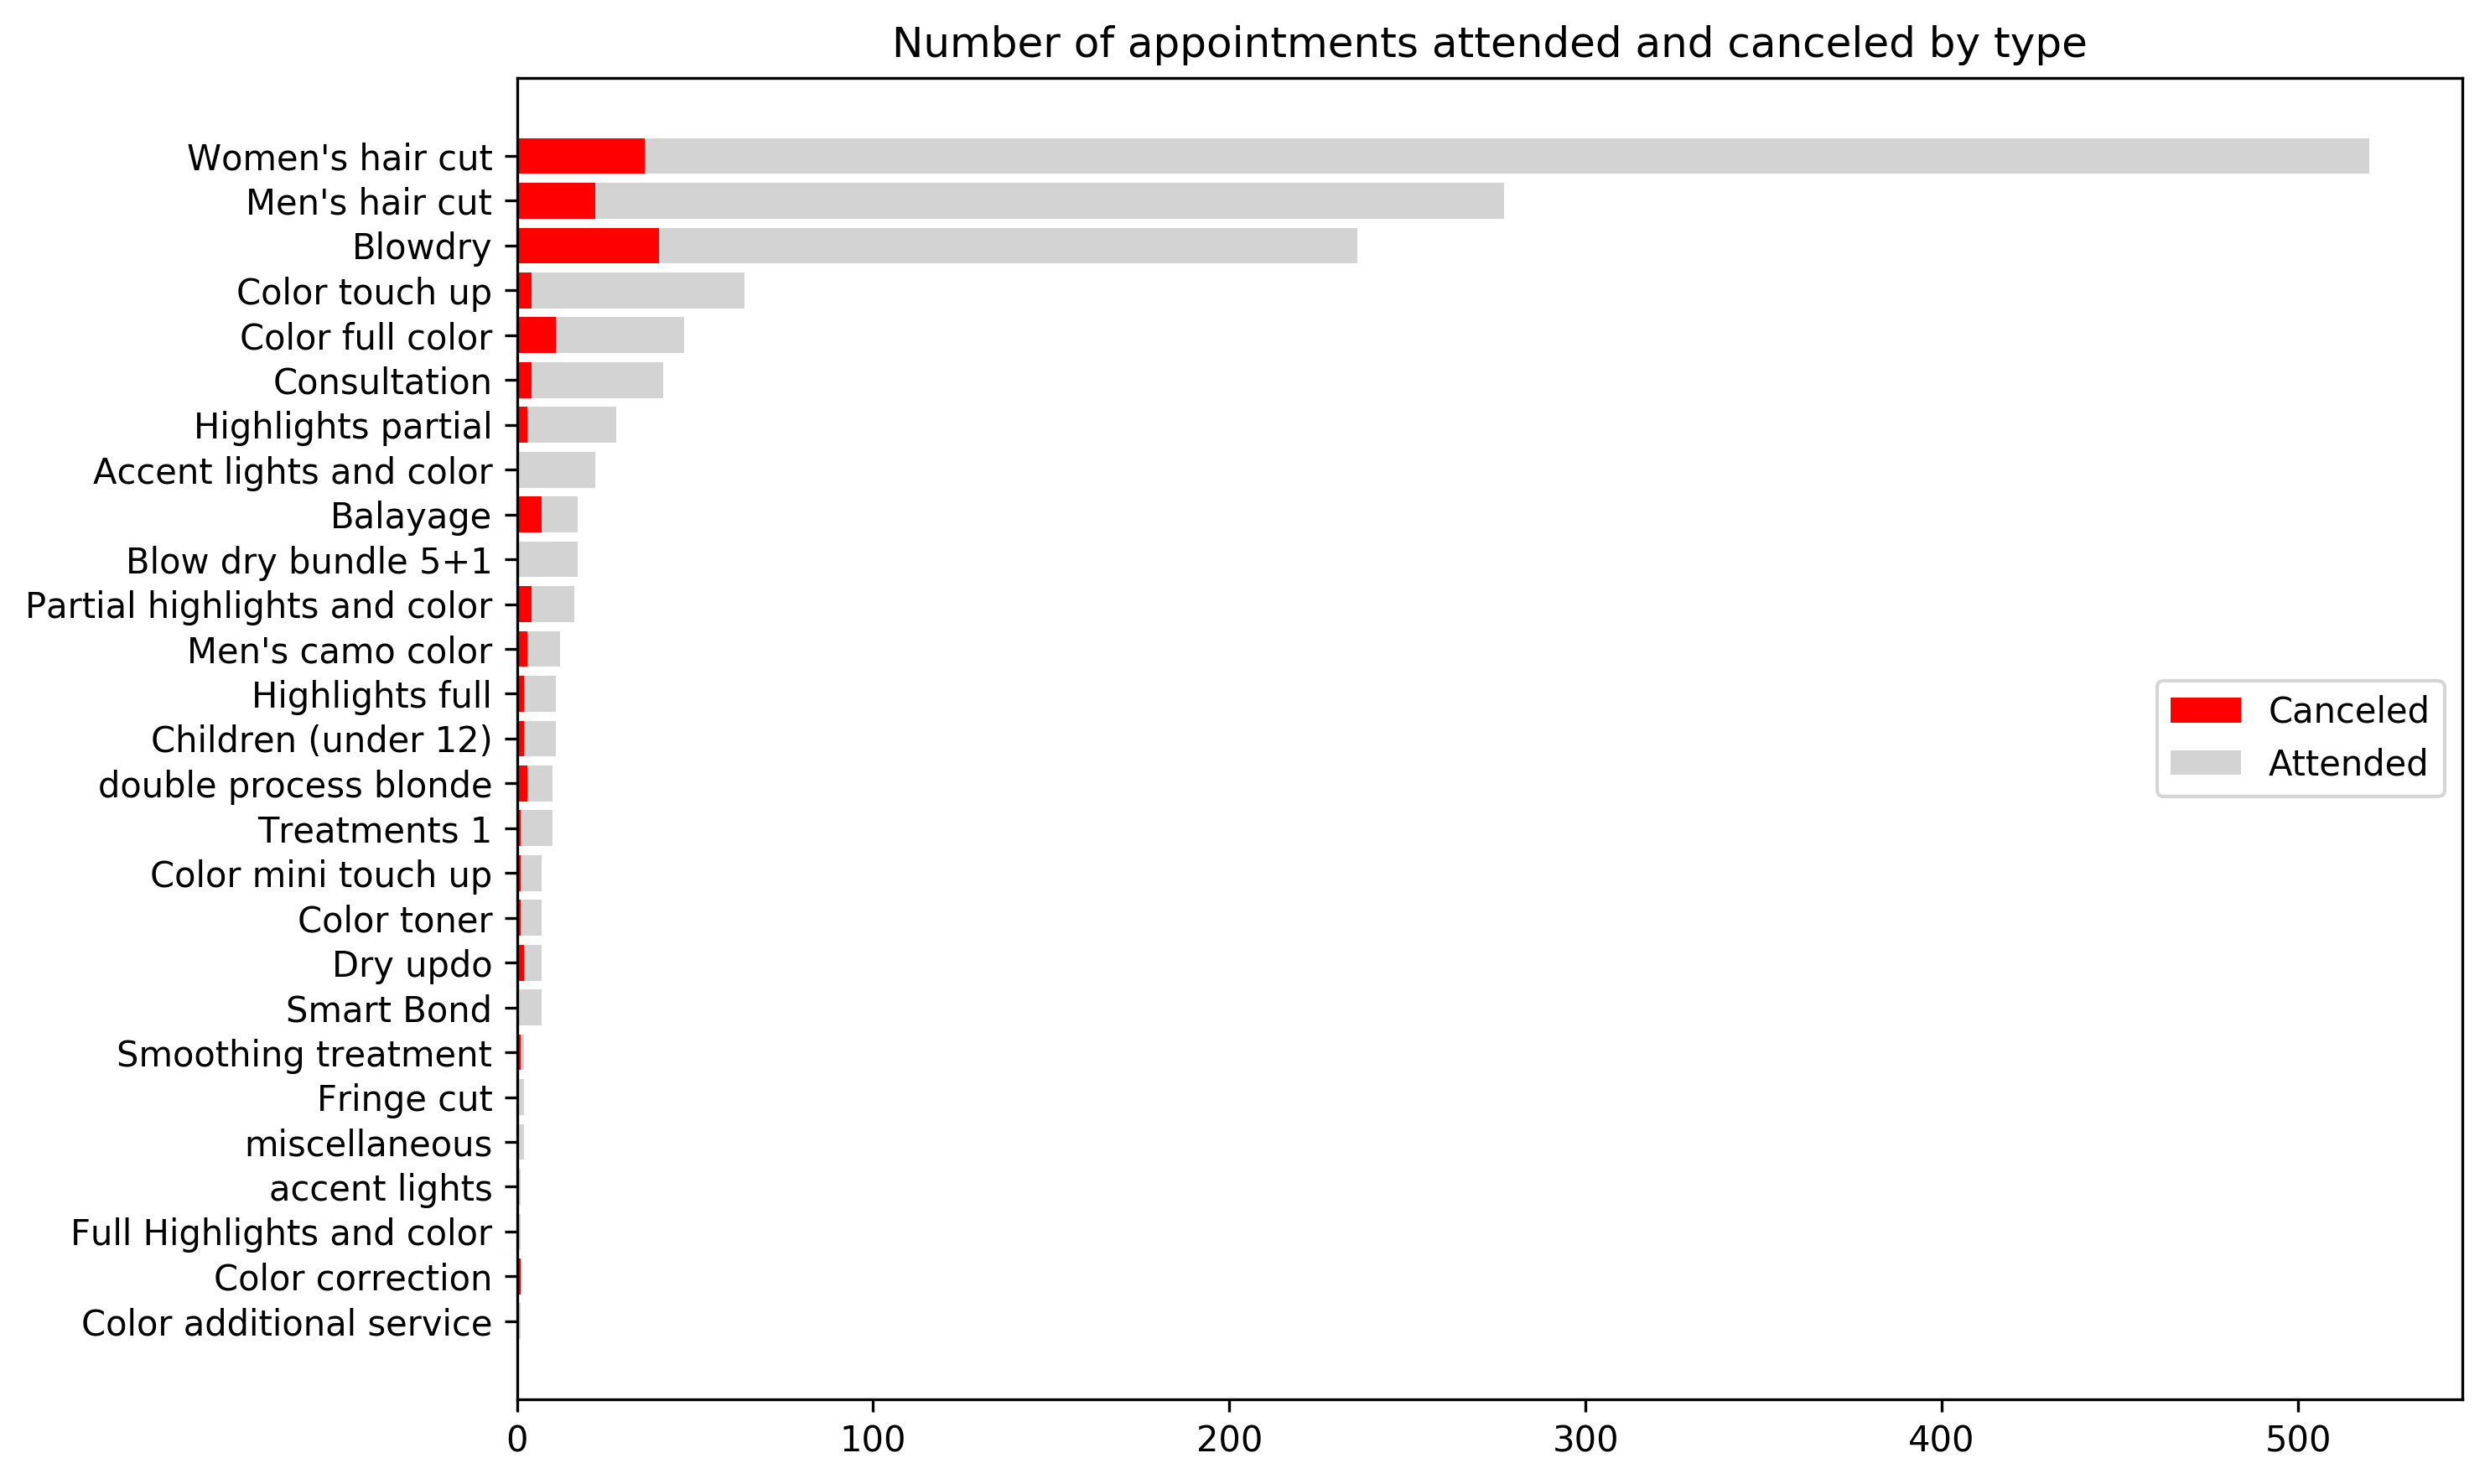

In [ ]:
## Fade out overall figures

fig = plt.figure(figsize=(10, 6), dpi=300)
p1 = plt.barh(y='service', width='canceled', data=q2_service, color='red')
p2 = plt.barh(y=q2_service['service'], width=(q2_service['count'] - q2_service['canceled']), left=q2_service['canceled'], color='lightgray')
plt.title('Number of appointments attended and canceled by type')
plt.legend(['Canceled', 'Attended'], loc='center right')
plt.tight_layout()
plt.savefig('canceled6.png')
plt.show()

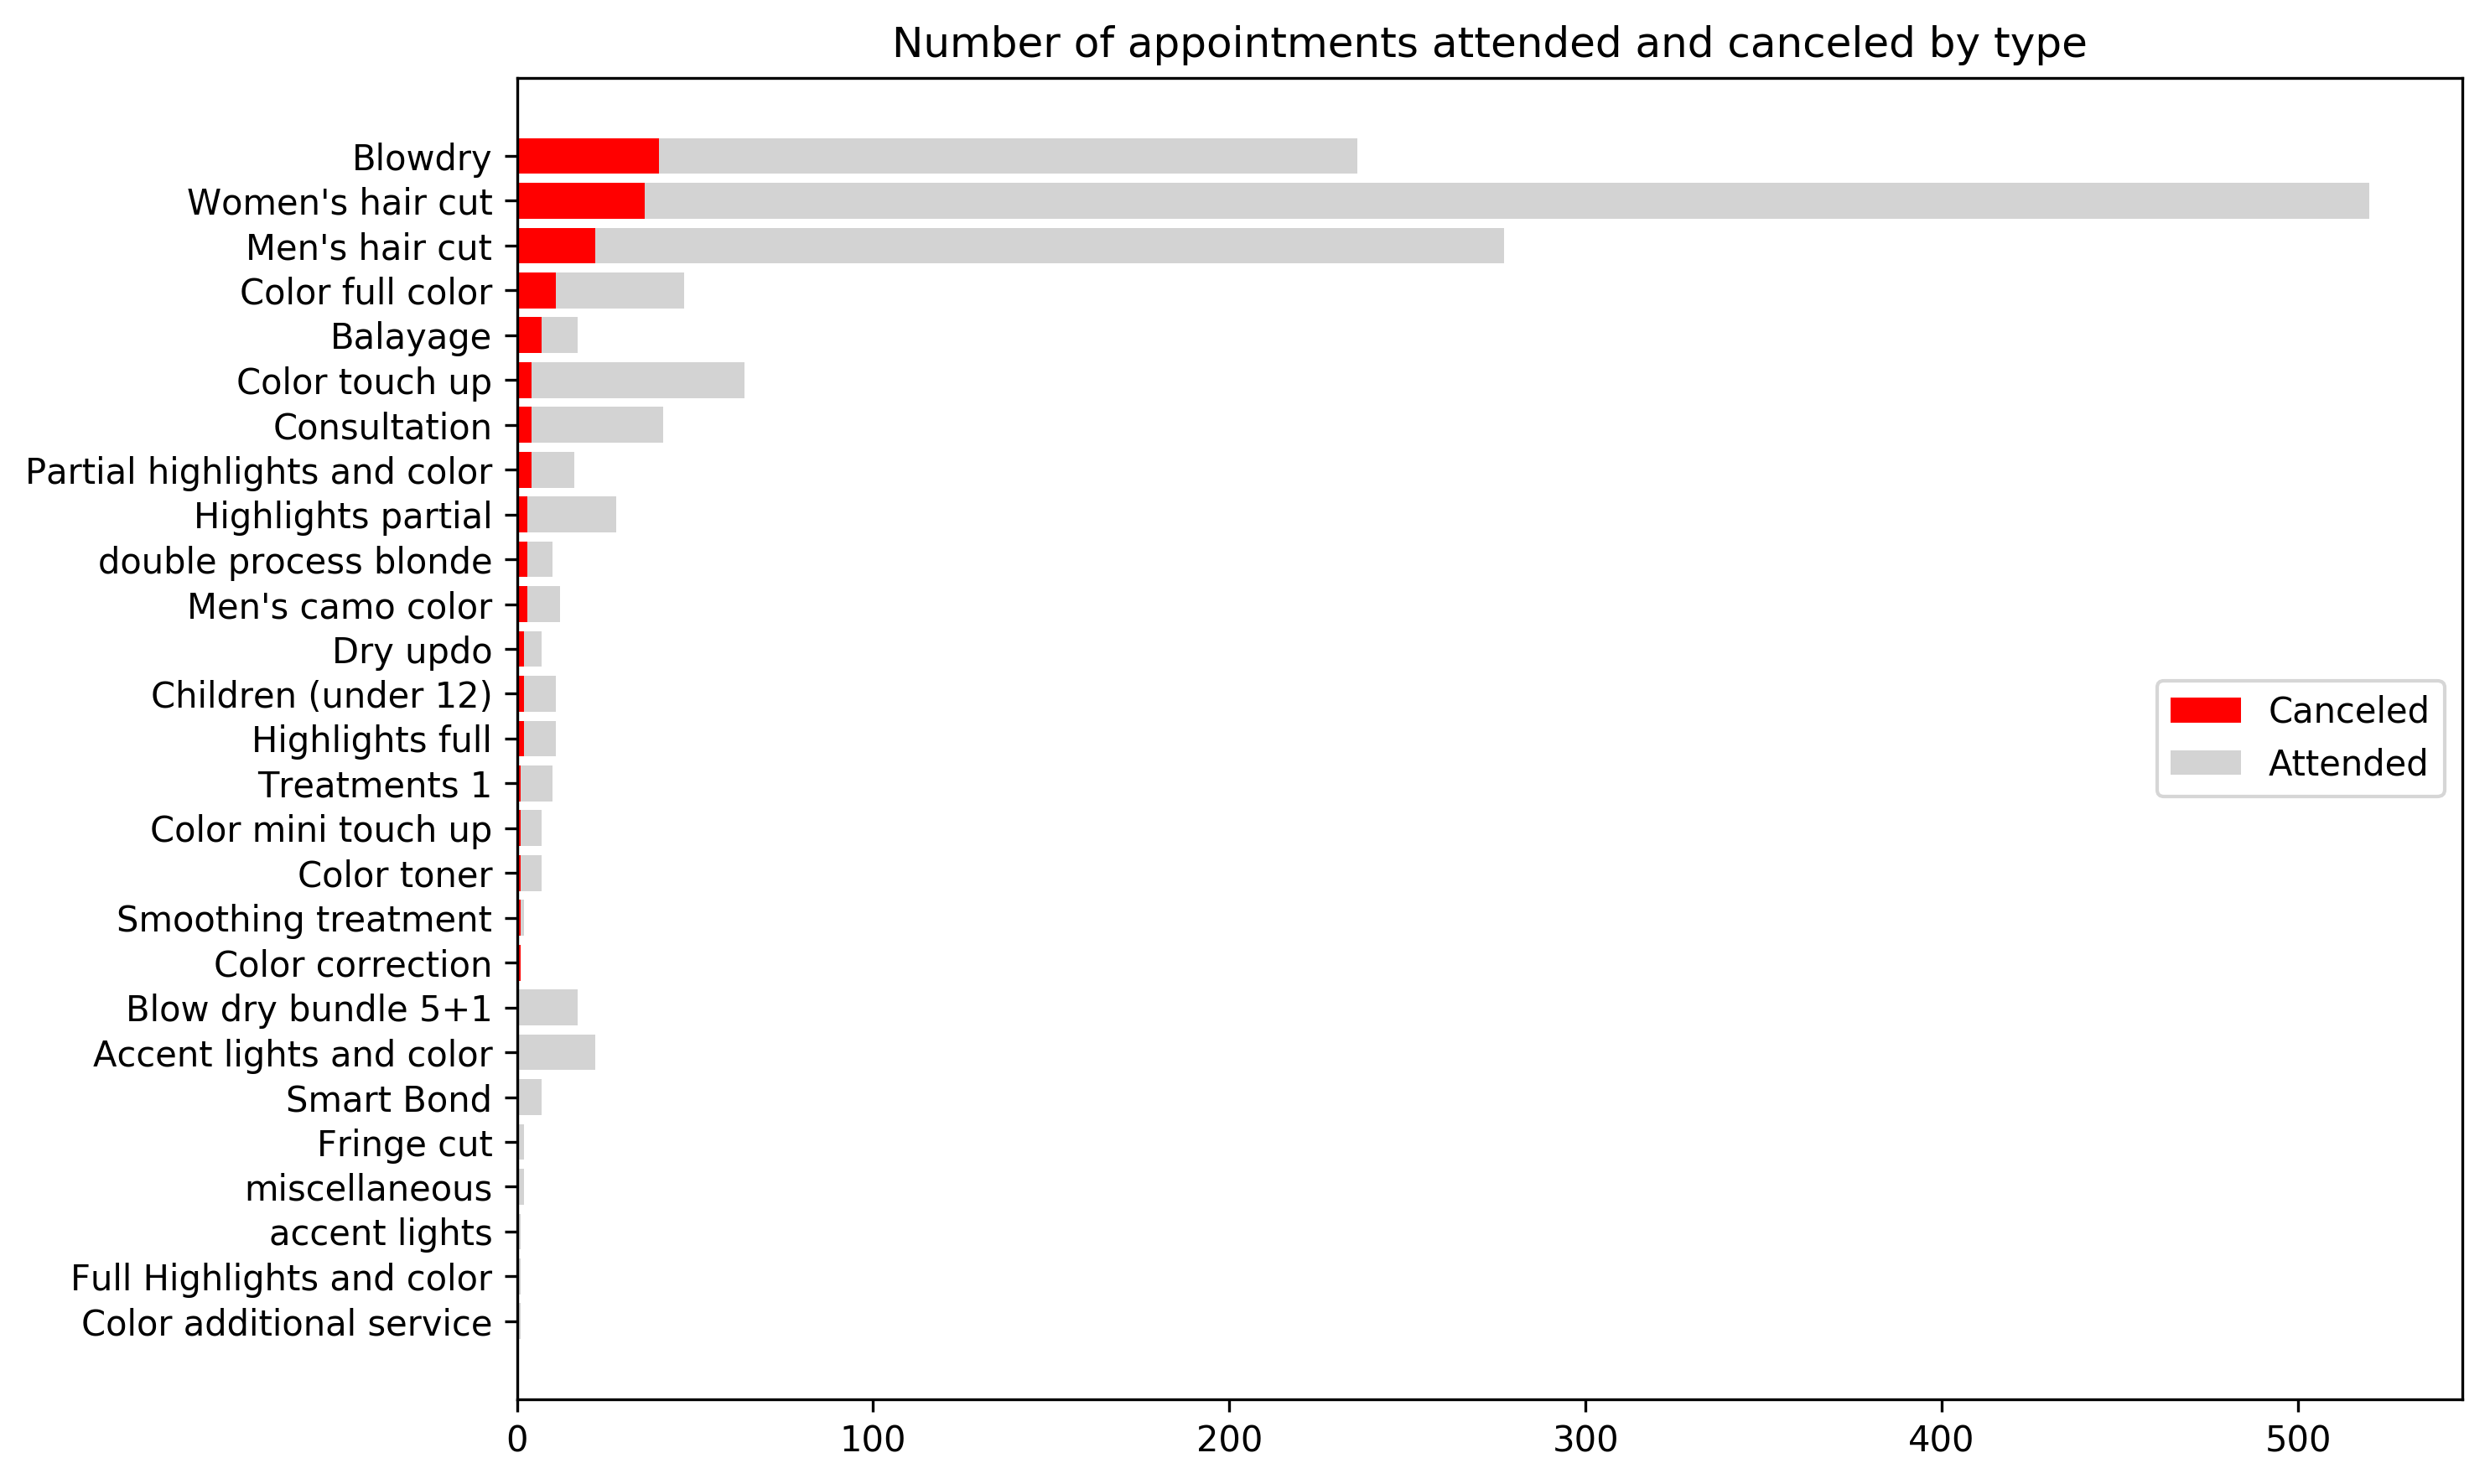

In [ ]:
## Rearrange by canceled

q2_service.sort_values('canceled', inplace=True, ascending=True)
fig = plt.figure(figsize=(10, 6), dpi=300)
p1 = plt.barh(y='service', width='canceled', data=q2_service, color='red')
p2 = plt.barh(y=q2_service['service'], width=(q2_service['count'] - q2_service['canceled']), left=q2_service['canceled'], color='lightgray')
plt.title('Number of appointments attended and canceled by type')
plt.legend(['Canceled', 'Attended'], loc='center right')
plt.tight_layout()
plt.savefig('canceled7.png')
plt.show()

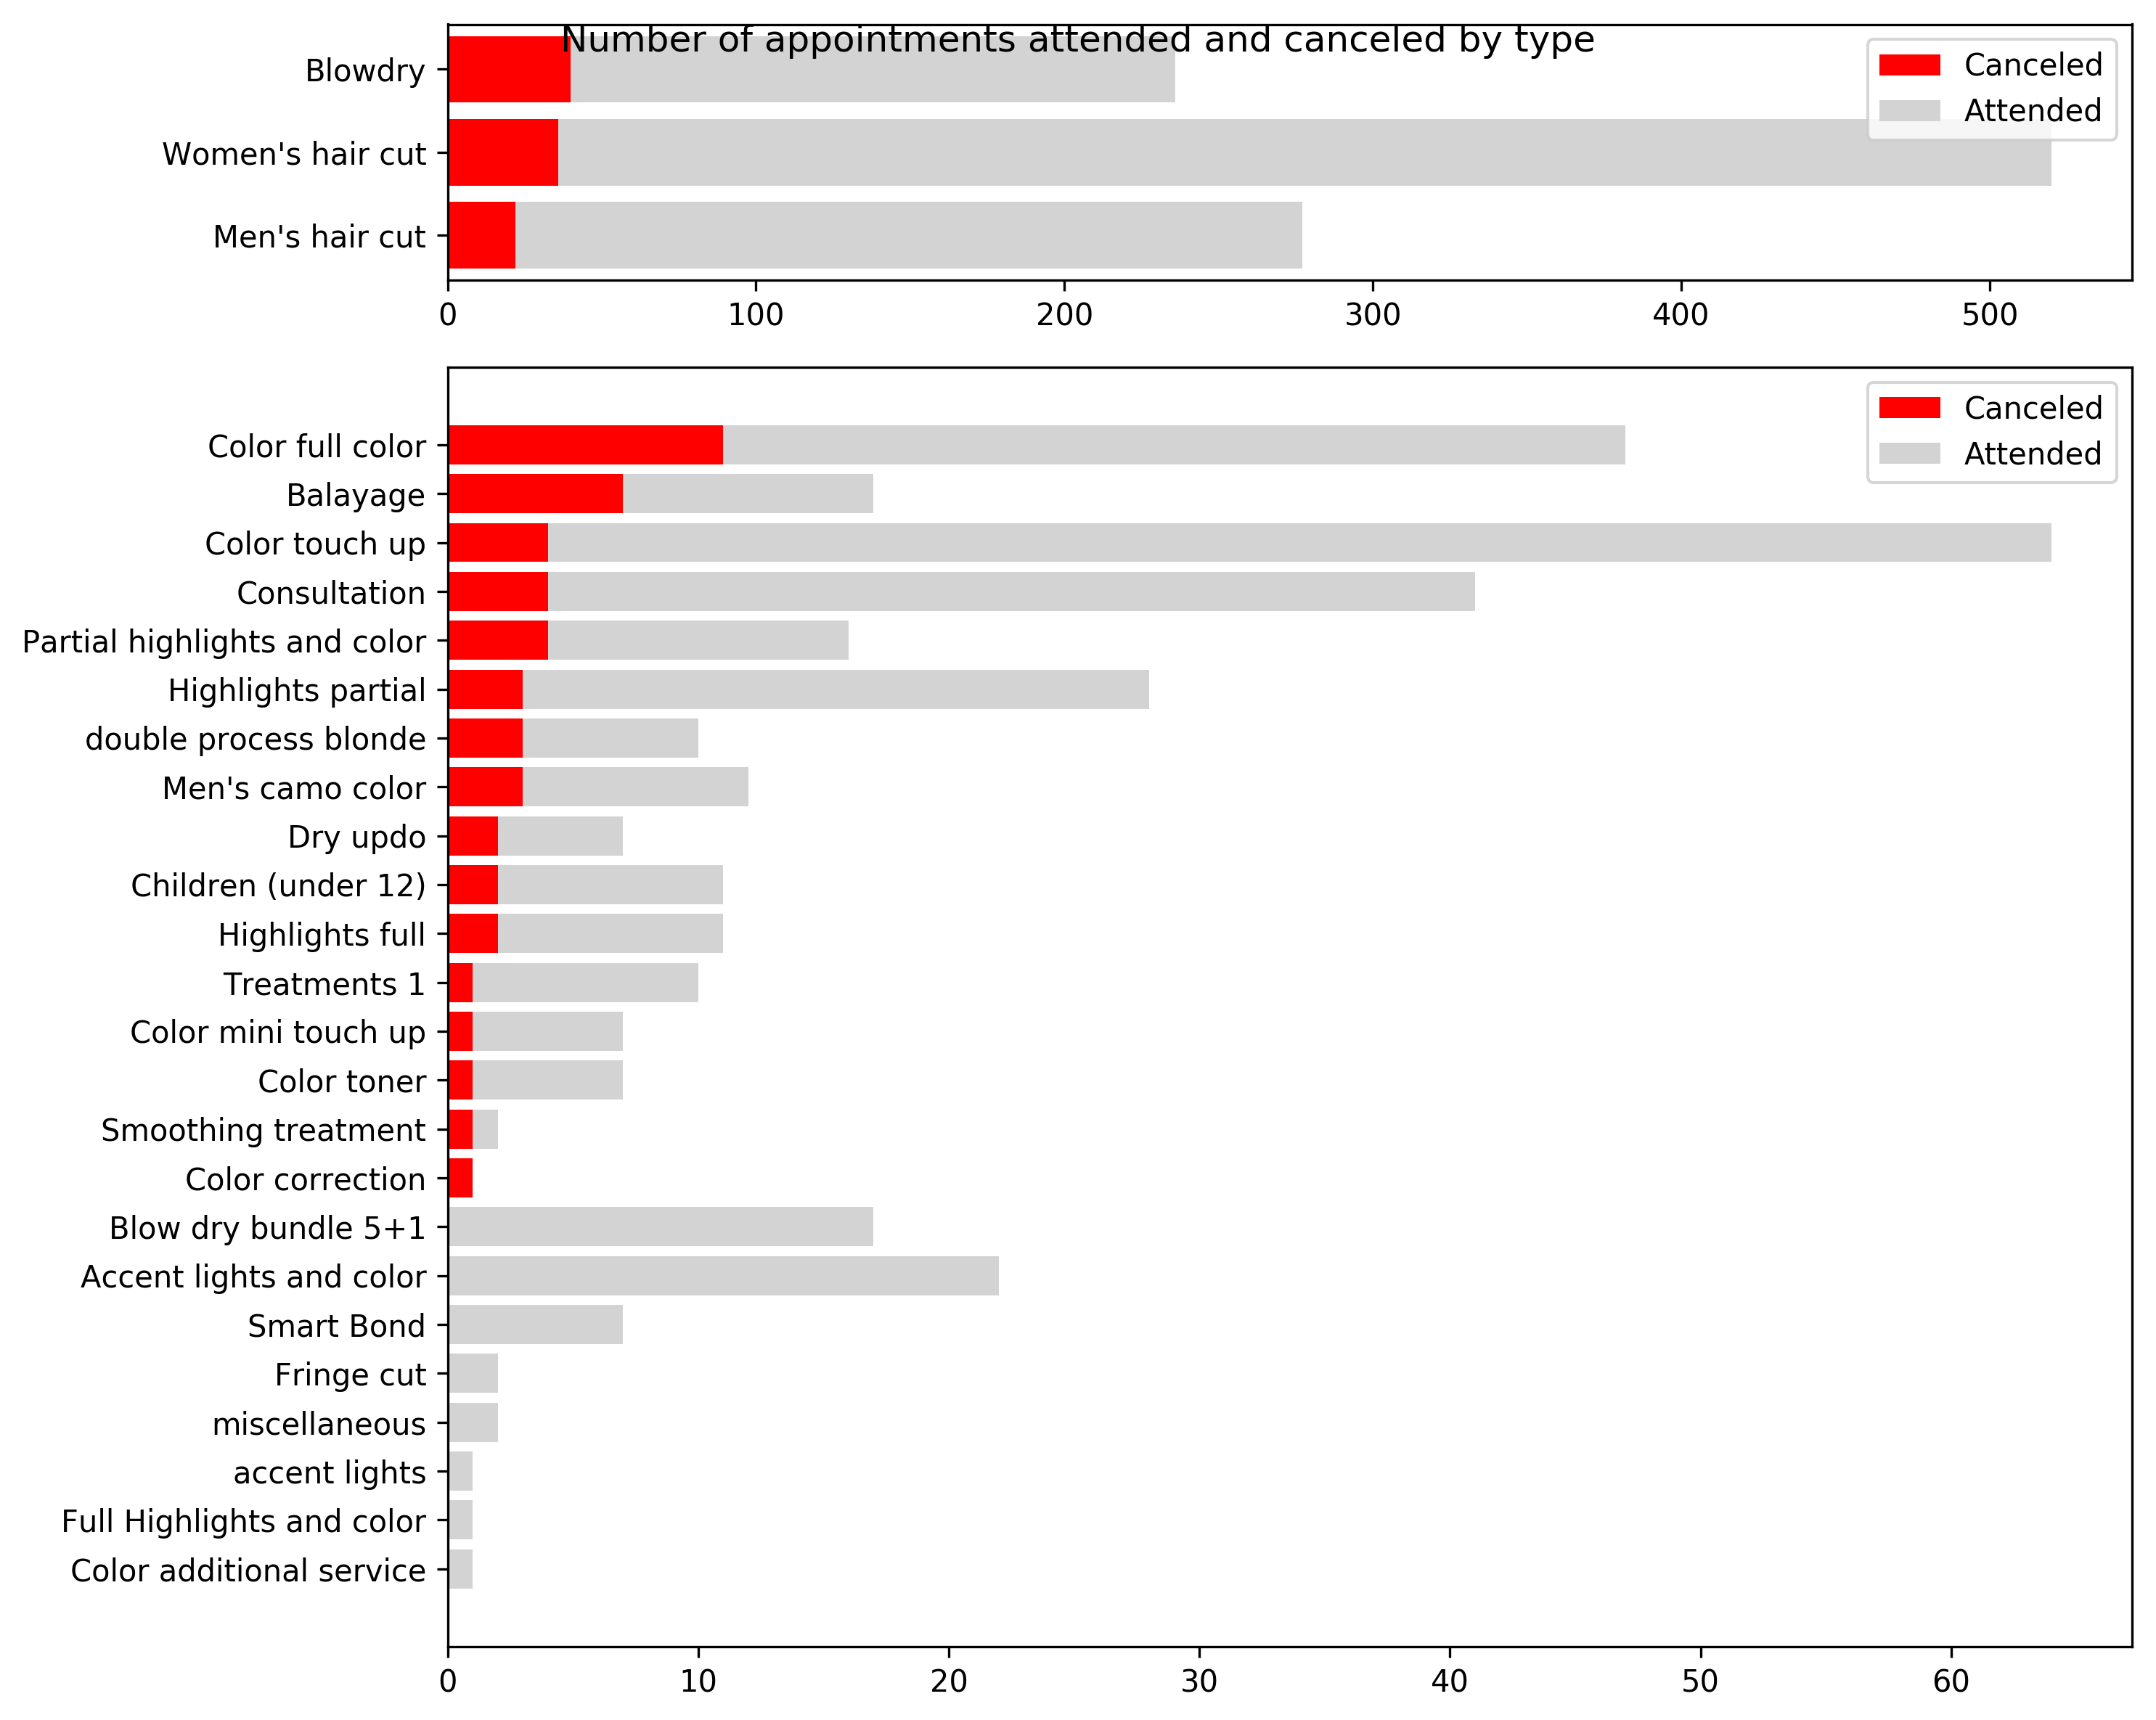

In [ ]:
## Split into two graphs again

top3_services = ['Blowdry', "Women's hair cut", "Men's hair cut"]
q2_service_top3 = q2_service[q2_service.service.isin(top3_services)]
q2_service_nottop3 = q2_service[~q2_service.service.isin(top3_services)]

fig = plt.figure(figsize=(10, 8), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios = [1, 5])

ax0 = plt.subplot(gs[0])
p2 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['canceled'], color='red')
p1 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['attended'], left=q2_service_top3['canceled'], color='lightgray')
plt.legend(['Canceled', 'Attended'])

ax1 = plt.subplot(gs[1])
p2 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['canceled'], color='red')
p1 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['attended'], left=q2_service_nottop3['canceled'], color='lightgray')
plt.legend(['Canceled', 'Attended'])

plt.suptitle('Number of appointments attended and canceled by type')
plt.tight_layout()
plt.savefig('canceled8.png')
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


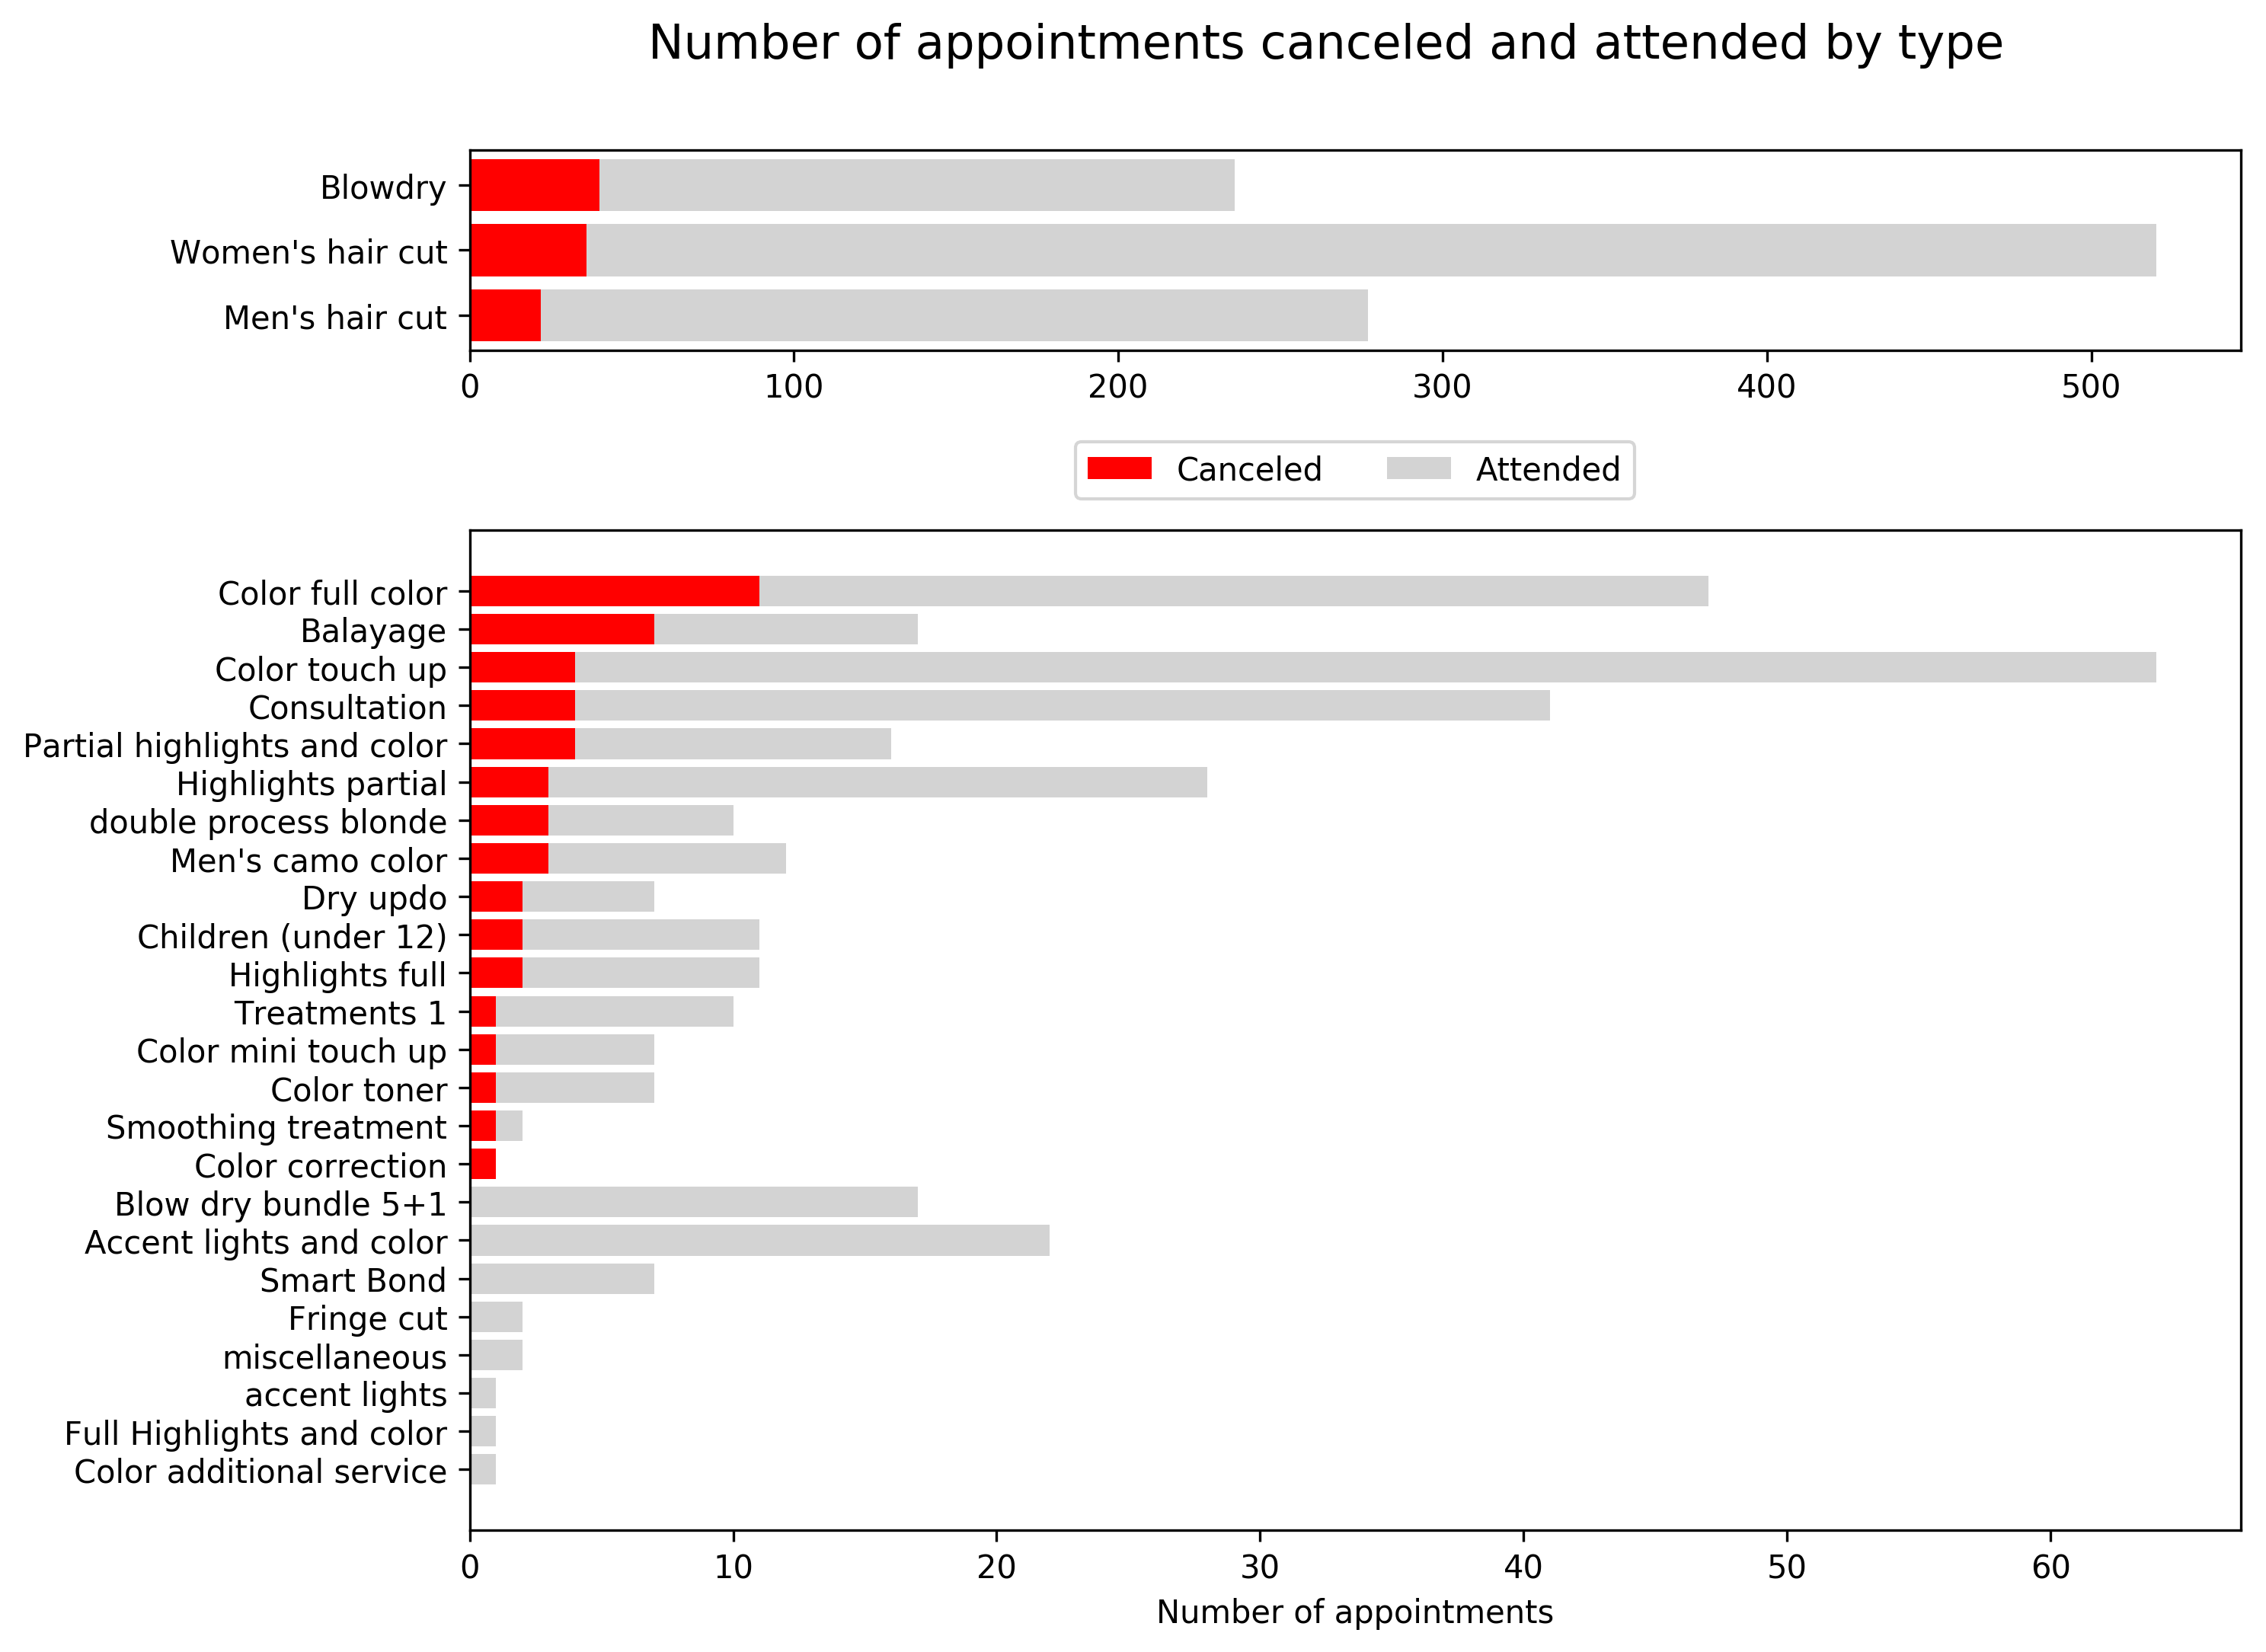

In [ ]:
## Fix legend position

fig = plt.figure(figsize=(10, 8), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios = [1, 5], hspace=0.3)

ax0 = plt.subplot(gs[0])
p2 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['canceled'], color='red')
p1 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['attended'], left=q2_service_top3['canceled'], color='lightgray')
plt.legend(['Canceled', 'Attended'], bbox_to_anchor=[0.5, -0.6], loc='center', ncol=2)

ax1 = plt.subplot(gs[1])
p2 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['canceled'], color='red')
p1 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['attended'], left=q2_service_nottop3['canceled'], color='lightgray')
plt.xlabel('Number of appointments')

plt.suptitle('Number of appointments canceled and attended by type', fontsize=15, y=0.95)
plt.tight_layout()
plt.savefig('canceled9.png', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


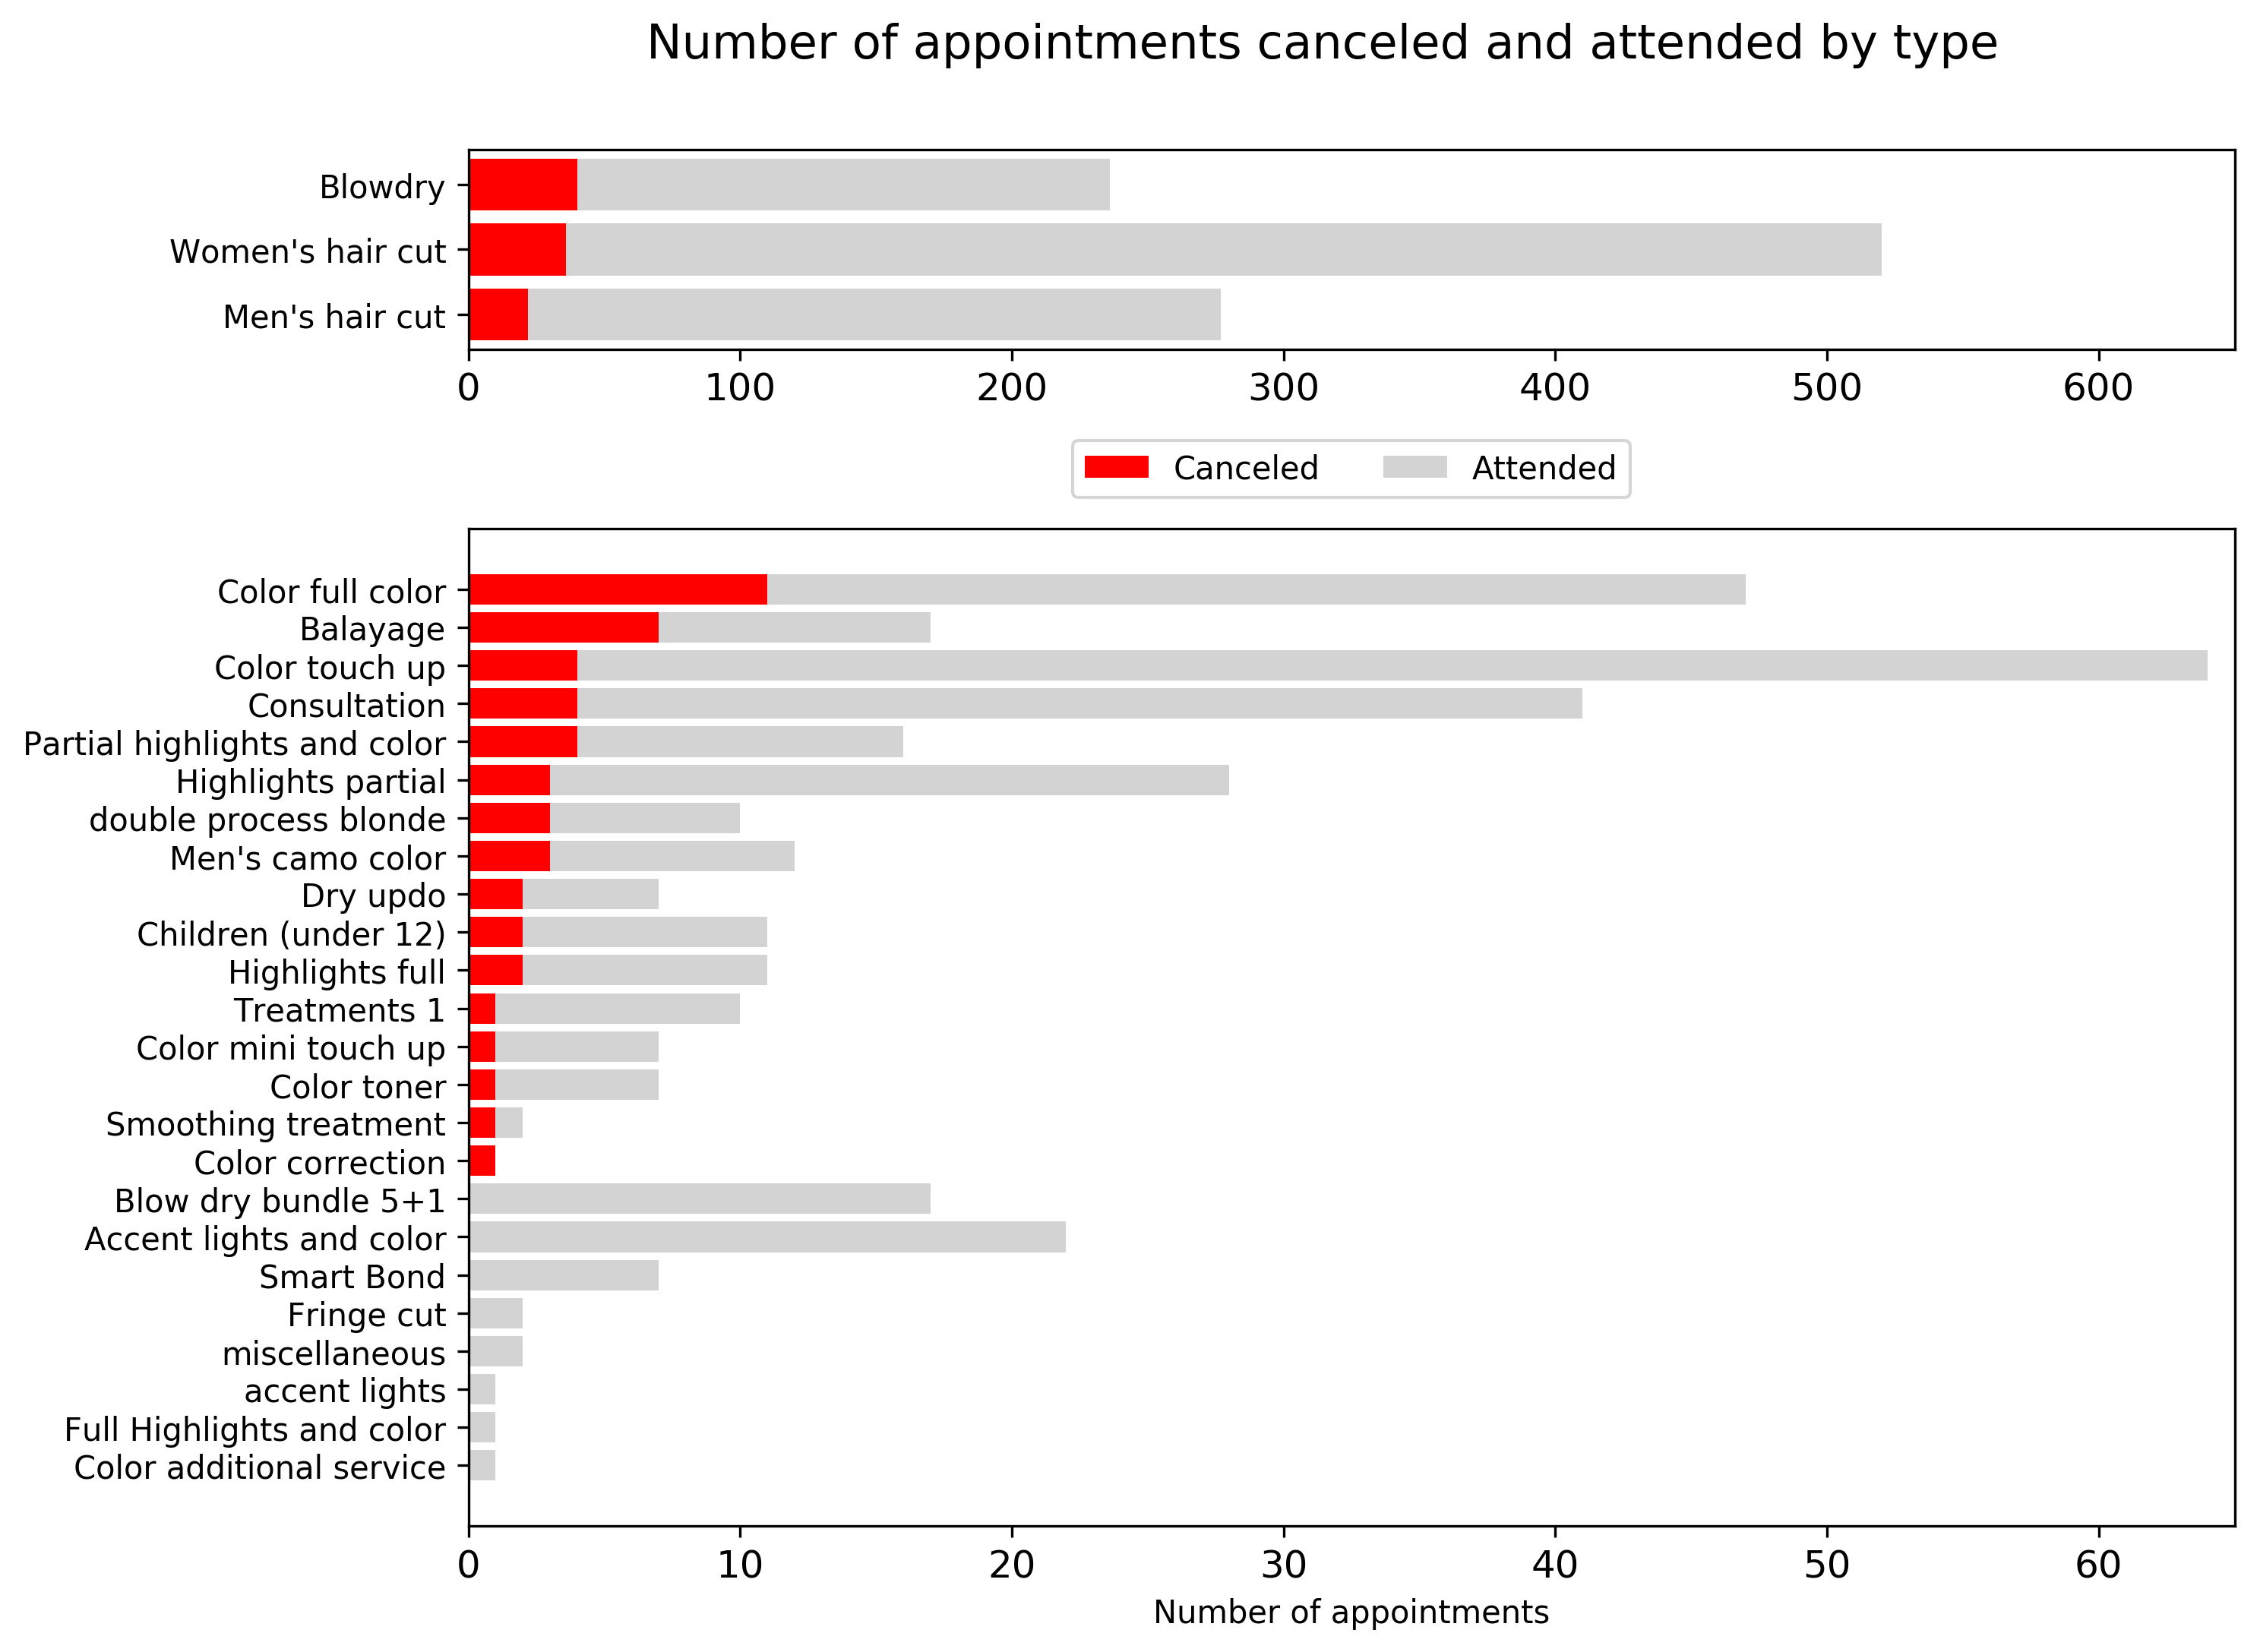

In [ ]:
## Change axes and increase font size

fig = plt.figure(figsize=(10, 8), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios = [1, 5], hspace=0.3)

ax0 = plt.subplot(gs[0])
p2 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['canceled'], color='red')
p1 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['attended'], left=q2_service_top3['canceled'], color='lightgray')
plt.legend(['Canceled', 'Attended'], bbox_to_anchor=[0.5, -0.6], loc='center', ncol=2)
plt.xlim([0, 650])
plt.xticks(fontsize=12)

ax1 = plt.subplot(gs[1])
p2 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['canceled'], color='red')
p1 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['attended'], left=q2_service_nottop3['canceled'], color='lightgray')
plt.xlabel('Number of appointments')
plt.xlim([0, 65])
plt.xticks(fontsize=12)

plt.suptitle('Number of appointments canceled and attended by type', fontsize=15, y=0.95)
plt.tight_layout()
plt.savefig('canceled10.png')
plt.show()

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


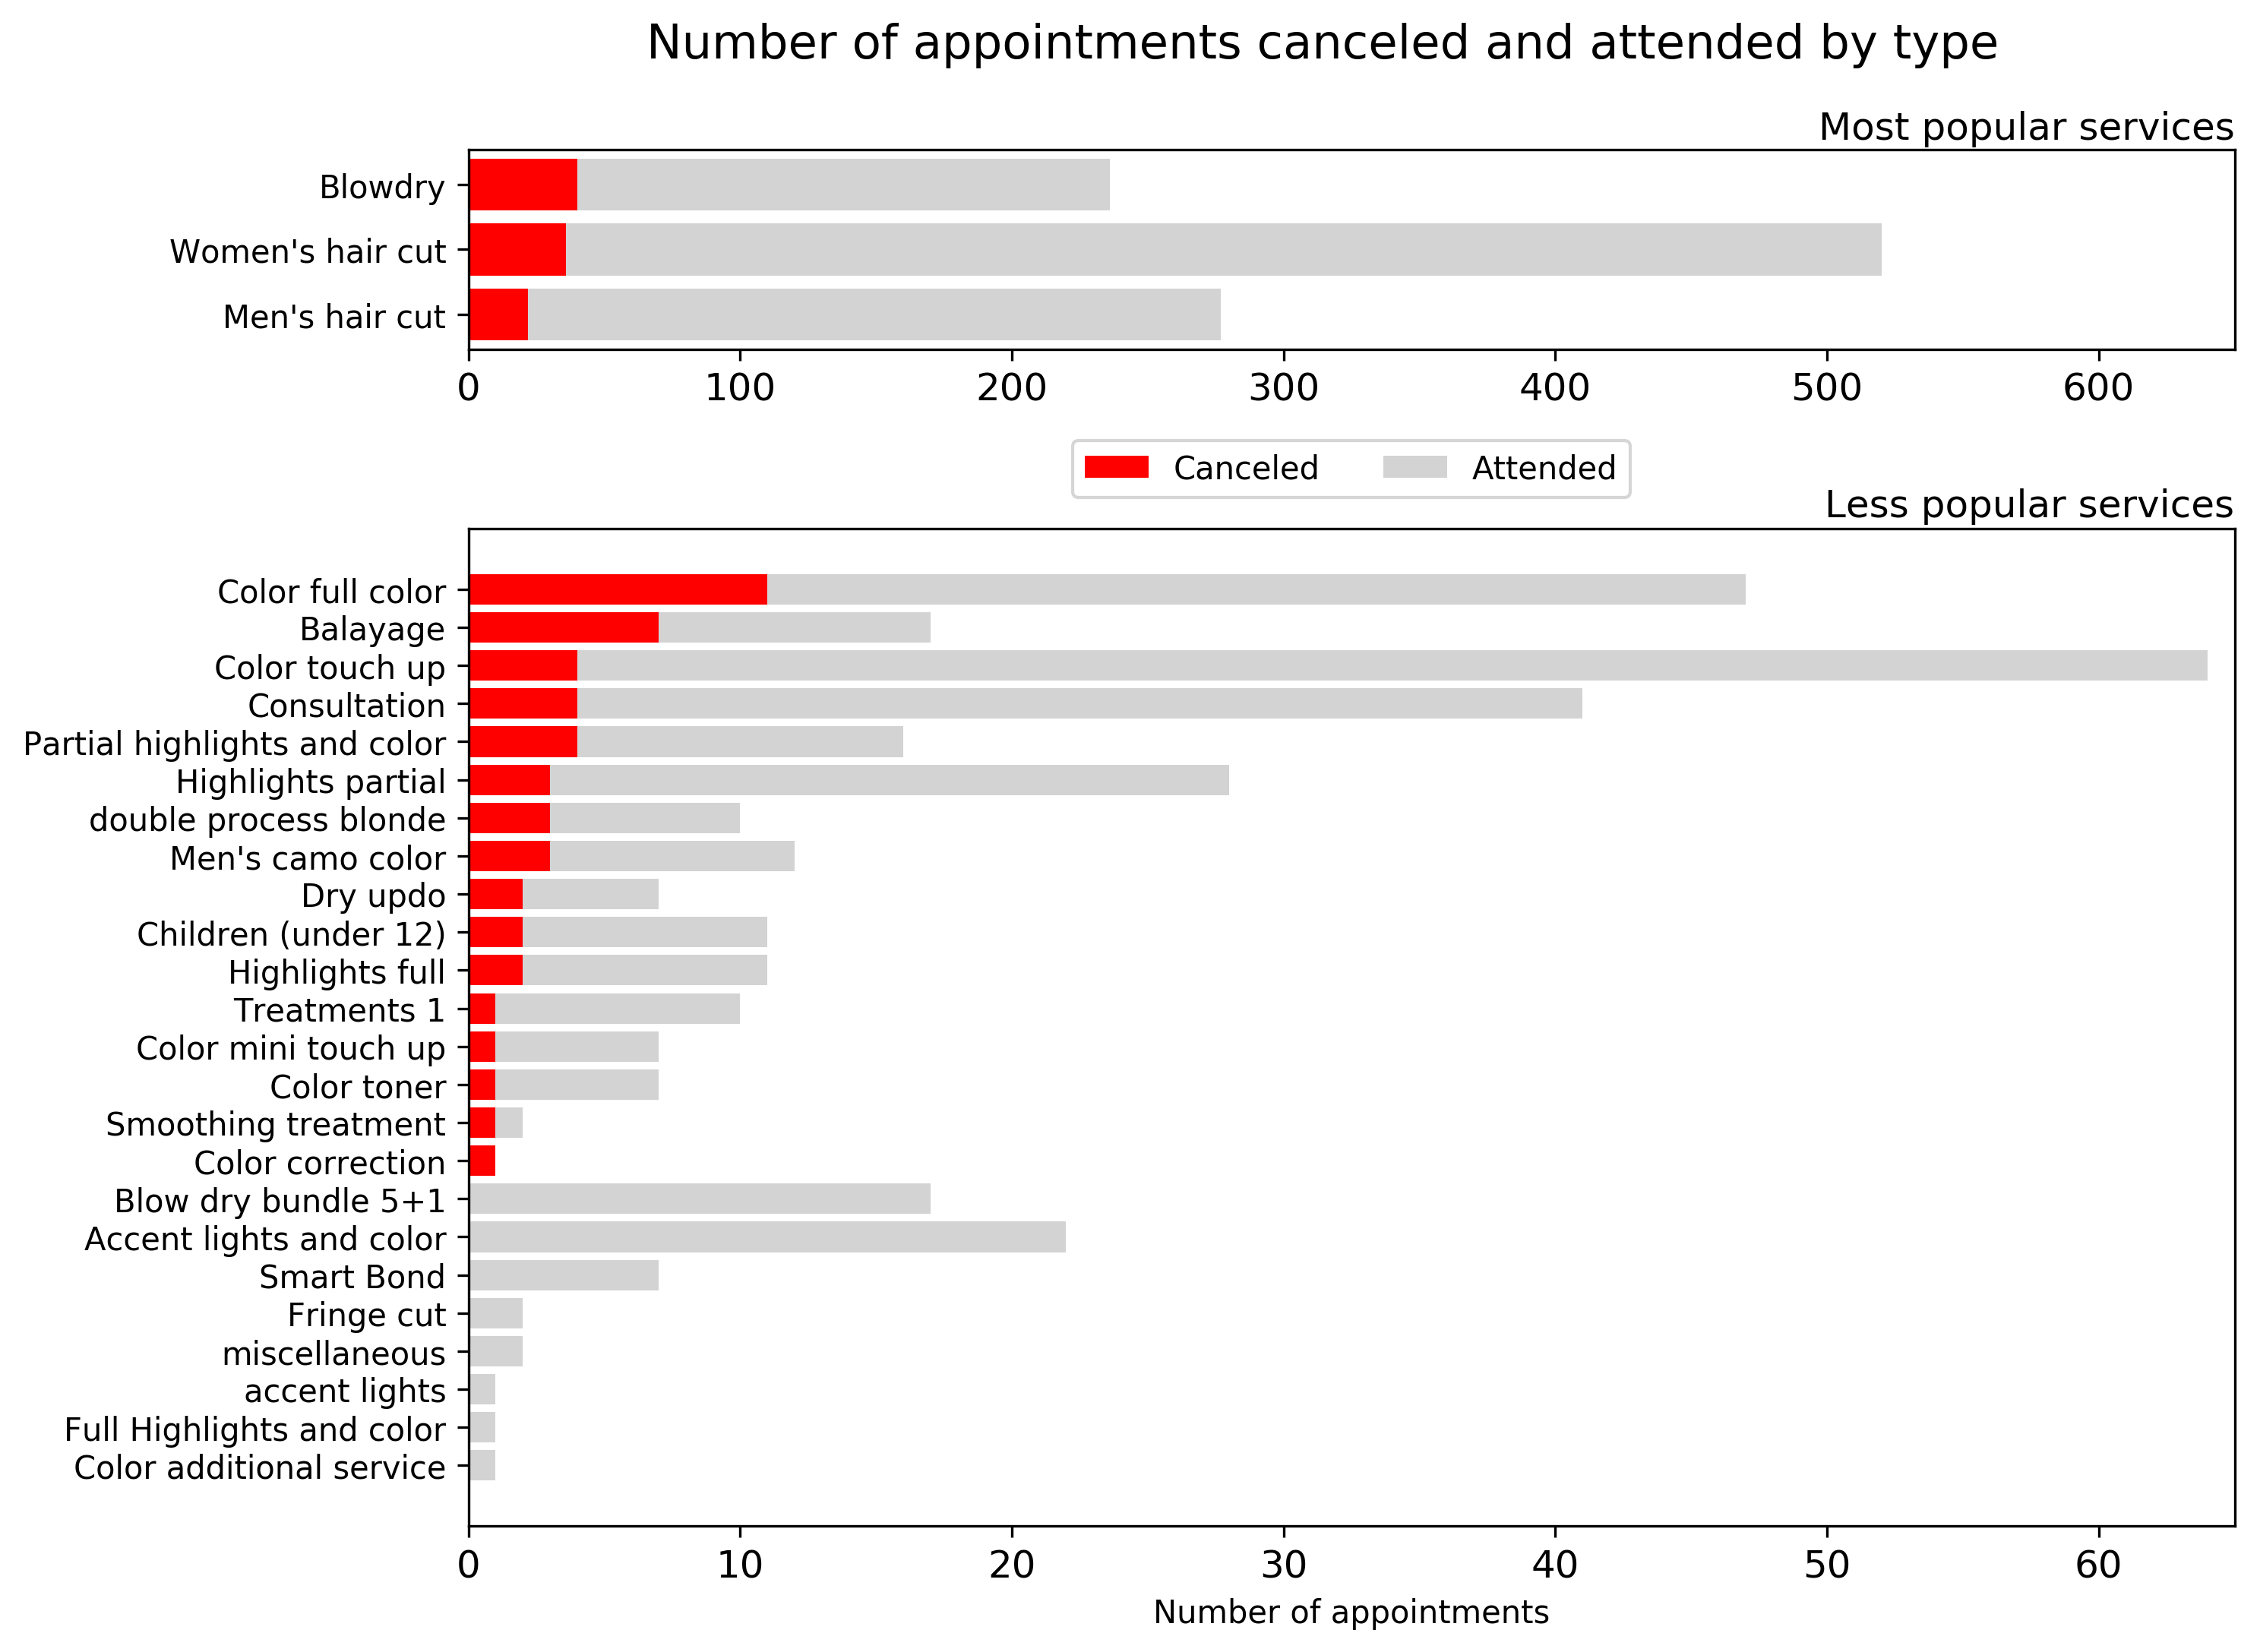

In [ ]:
## Include annotations

fig = plt.figure(figsize=(10, 8), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios = [1, 5], hspace=0.3)

ax0 = plt.subplot(gs[0])
p2 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['canceled'], color='red')
p1 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['attended'], left=q2_service_top3['canceled'], color='lightgray')
plt.legend(['Canceled', 'Attended'], bbox_to_anchor=[0.5, -0.6], loc='center', ncol=2)
plt.xlim([0, 650])
plt.xticks(fontsize=12)
ax0.annotate('Most popular services', xy=(650, 2.7), ha='right', 
             annotation_clip=False, fontsize=12)

ax1 = plt.subplot(gs[1])
p2 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['canceled'], color='red')
p1 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['attended'], left=q2_service_nottop3['canceled'], color='lightgray')
plt.xlabel('Number of appointments')
plt.xlim([0, 65])
plt.xticks(fontsize=12)
ax1.annotate('Less popular services', xy=(65, 24.9), ha='right', 
             annotation_clip=False, fontsize=12)

plt.suptitle('Number of appointments canceled and attended by type', fontsize=15,
            y=0.95)
plt.tight_layout()
plt.savefig('canceled11.png')
plt.show()

In [ ]:
## Fade spines so annotations more visible

with plt.rc_context({'axes.edgecolor': 'grey'}):

    fig = plt.figure(figsize=(10, 8), dpi=300)
    gs = gridspec.GridSpec(2, 1, height_ratios = [1, 5], hspace=0.3)

    ax0 = plt.subplot(gs[0])
    p2 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['canceled'], color='red')
    p1 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['attended'], left=q2_service_top3['canceled'], color='lightgray')
    plt.legend(['Canceled', 'Attended'], bbox_to_anchor=[0.5, -0.6], loc='center', ncol=2)
    plt.xlim([0, 650])
    plt.xticks(fontsize=12)
    ax0.annotate('Most popular services', xy=(650, 2.7), ha='right', 
                 annotation_clip=False, fontsize=12)

    ax1 = plt.subplot(gs[1])
    p2 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['canceled'], color='red')
    p1 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['attended'], left=q2_service_nottop3['canceled'], color='lightgray')
    plt.xlabel('Number of appointments')
    plt.xlim([0, 65])
    plt.xticks(fontsize=12)
    ax1.annotate('Less popular services', xy=(65, 24.9), ha='right', 
                 annotation_clip=False, fontsize=12)

    plt.suptitle('Number of appointments canceled and attended by type', fontsize=15,
                y=0.95)
    plt.tight_layout()
    plt.savefig('canceled12.png', bbox_inches='tight')
    plt.show()

In [ ]:
## Remove spines so annotations more visible?

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 1, height_ratios = [1, 5], hspace=0.3)

ax0 = plt.subplot(gs[0])
p2 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['canceled'], color='red')
p1 = plt.barh(y=q2_service_top3['service'], width=q2_service_top3['attended'], left=q2_service_top3['canceled'], color='lightgray')
plt.legend(['Canceled', 'Attended'], bbox_to_anchor=[0.5, -0.6], loc='center', ncol=2)
plt.xlim([0, 650])
plt.xticks(fontsize=12)
ax0.annotate('Most popular services', xy=(0, 2.7), ha='left', 
             annotation_clip=False, fontsize=12)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1 = plt.subplot(gs[1])
p2 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['canceled'], color='red')
p1 = plt.barh(y=q2_service_nottop3['service'], width=q2_service_nottop3['attended'], left=q2_service_nottop3['canceled'], color='lightgray')
plt.xlabel('Number of appointments')
plt.xlim([0, 65])
plt.xticks(fontsize=12)
ax1.annotate('Less popular services', xy=(0, 24.9), ha='left', 
             annotation_clip=False, fontsize=12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.suptitle('Number of appointments canceled and attended by type', fontsize=15,
            y=0.95)
plt.show()

In [ ]:
## Featured image

q2_service.sort_values('count', inplace=True, ascending=False)
top3_services = ['Blowdry', "Women's hair cut", "Men's hair cut"]
q2_service_top3 = q2_service[q2_service.service.isin(top3_services)]
q2_service_nottop3 = q2_service[~q2_service.service.isin(top3_services)]

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

p1 = plt.bar(x=q2_service_nottop3['service'], height=q2_service_nottop3['attended'], color='red', label=None)
p2 = plt.bar(x=q2_service_nottop3['service'], height=q2_service_nottop3['canceled'], color='blue', bottom=(q2_service_nottop3['attended']), label=None)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('canceled-feature.png')
plt.show()